## Problem Statement -

Today the study of financial credit risk assessment attracts increasing attentions in the face of one of the most severe financial crisis ever observed in the world. The accurate assessment of financial credit risk and prediction of business failure play an essential role both on economics and society.

Credit risk management is the practice of mitigating losses by understanding the adequacy of a bank’s capital and loan loss reserves at any given time – a process that has long been a challenge for financial institutions.

The global financial crisis – and the credit crunch that followed – put credit risk management into the regulatory spotlight. As a result, regulators began to demand more transparency. They wanted to know that a bank has thorough knowledge of customers and their associated credit risk. And new Basel III regulations will create an even bigger regulatory burden for banks.

To comply with the more stringent regulatory requirements and absorb the higher capital costs for credit risk, many banks are overhauling their approaches to credit risk. But banks who view this as strictly a compliance exercise are being short-sighted. Better credit risk management also presents an opportunity to greatly improve overall performance and secure a competitive advantage.


### 1) Import libraries/ Dipendancies -

In [2]:
# Importing libraries for Data Manipulation
import pandas as pd
import numpy as np
import json
import pickle

# Libraries which are required for maodel training and Evaluation
from scipy.stats import zscore,mode
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score
from sklearn.metrics import precision_score,recall_score,confusion_matrix,precision_recall_curve
from sklearn.metrics import accuracy_score,classification_report,f1_score,roc_curve
from sklearn.preprocessing import StandardScaler,OneHotEncoder,OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

# Importing warnings to filter warnings and ignore them
import warnings
warnings.filterwarnings("ignore")

# Importing Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt 
import plotly.express as ex
import matplotlib
from IPython.display import display
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
%matplotlib inline

# Importing Libraries to generate pandas Profilling Report
import pandas_profiling
import ydata_profiling
from collections import Counter

### 2) Data Gathering and Data Validitation - 

Recieved data according to Schema file and got the data. for DQ check we have used Microsoft Excel.

In [3]:
# Reading CSV File -
df = pd.read_csv("credit_risk_dataset.csv")
df.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y                           3  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4

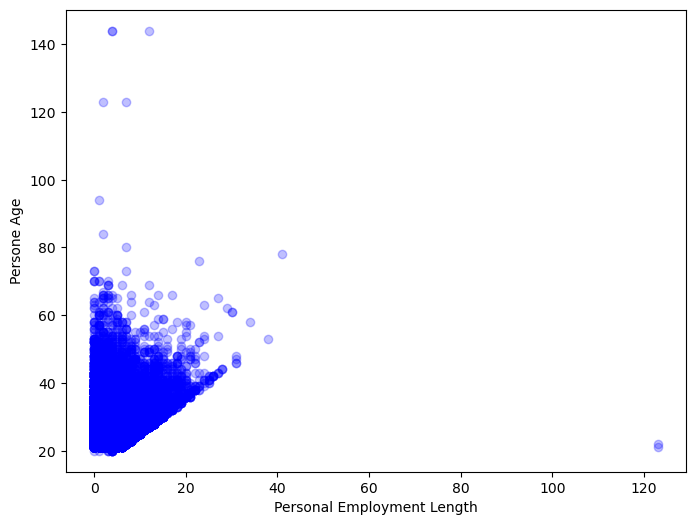

In [4]:
# plots a scatter plot of pesonal employment length against age
plt.figure(figsize=(8, 6))

plt.scatter(df['person_emp_length'], df['person_age'], color='blue', alpha=0.25)
plt.xlabel('Personal Employment Length')
plt.ylabel('Persone Age')

plt.ticklabel_format(useOffset=False, style='plain')
plt.show()

Here we can see the higher correlation between age and income as they are may working from long time in the company,
we can also see the outliers in the data. Persons age above 100 years is not feasible in the any sense. the person 
whoes age is above 100 years he or she not going to apply for loan in any condition. If there is entry of that case 
then this person is definitely going to default. In case of person employment length above 60 years length is not 
feasible in the buisness scenario.

In [5]:
# checking for indices of persons employment length grater than 60
indices = df[df["person_emp_length"] > 60].index
indices

Int64Index([0, 210], dtype='int64')

on the indices 0 and 210 there are ahe outliers so after discussion with buisness experties will remove those.
we have got 2 outliers in the data.

In [6]:
# length of records where outliers are present 
len(indices)

2

In [7]:
# Checking for which records will be dropped
df.loc[[0,210]]

person_age  person_income person_home_ownership  person_emp_length  \
0            22          59000                  RENT              123.0   
210          21         192000              MORTGAGE              123.0   

    loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0      PERSONAL          D      35000          16.02            1   
210     VENTURE          A      20000           6.54            0   

     loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                   0.59                         Y                           3  
210                 0.10                         N                           4

In [8]:
# Dropping the records based on the indices
df_1 = df.drop([0,210],axis=0)
df_1.head()

person_age  person_income person_home_ownership  person_emp_length  \
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   
5     VENTURE          A       2500           7.14            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4  
5                 0.25                         N                           2

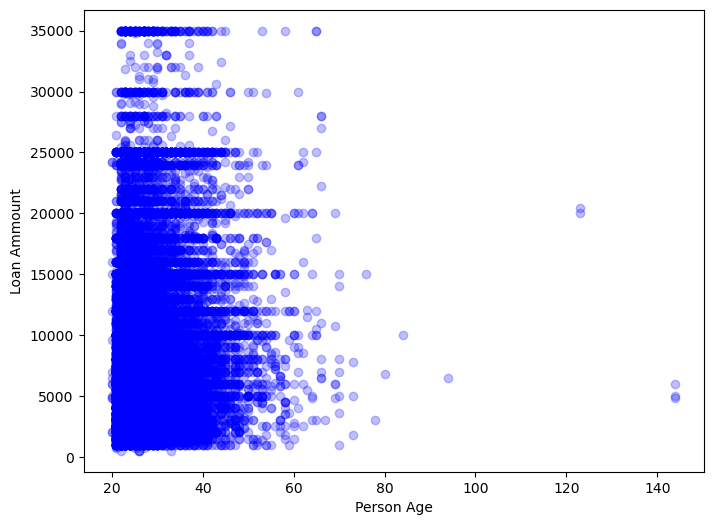

In [9]:
# plots a scatter plot of pesonal employment length against age
plt.figure(figsize=(8,6))
plt.scatter(df_1["person_age"],df_1["loan_amnt"],color = "blue",alpha=0.25)
plt.xlabel("Person Age")
plt.ylabel("Loan Ammount")
plt.show()

We discovered outliers in person_emp_length where values greater than 60 were far above the norm. person_age
is another column in which a person can use a common sense approach to say it is very unlikely that a person
applying for a loan will be over 100 years old.

In [10]:
# checking for indices of persons employment length grater than 100
indices = df_1[df_1["person_age"] > 100].index
indices

Int64Index([81, 183, 575, 747, 32297], dtype='int64')

In [11]:
# we are dropping those Entries from df and creating new df
df_2 = df_1.drop([81, 183, 575, 747, 32297],axis=0)
df_2.head()

person_age  person_income person_home_ownership  person_emp_length  \
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   
5     VENTURE          A       2500           7.14            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
1                 0.10                         N                           2  
2                 0.57                         N                           3  
3                 0.53                         N                           2  
4                 0.55                         Y                           4  
5                 0.25                         N                           2

### 3) EDA (Exploratory Data Analysis) - 

In [ ]:
Steps Involved in EDA - 
    1) Information about Datset
    2) Describe Dataset
    3) Find Missing Values / Percentage of Missing Values
    4) Value Counts of Each Object Feature
    4) Desciding Encoding Types
    5) Outliers Detection
    6) Correlation with Target Feature
    7) VIF (Variance Inflation Factor)
    8) Status of Target Feature
    9) EDA report

- Information about Datset

In [12]:
# Checking information of dataset
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32574 entries, 1 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32574 non-null  int64  
 1   person_income               32574 non-null  int64  
 2   person_home_ownership       32574 non-null  object 
 3   person_emp_length           31679 non-null  float64
 4   loan_intent                 32574 non-null  object 
 5   loan_grade                  32574 non-null  object 
 6   loan_amnt                   32574 non-null  int64  
 7   loan_int_rate               29459 non-null  float64
 8   loan_status                 32574 non-null  int64  
 9   loan_percent_income         32574 non-null  float64
 10  cb_person_default_on_file   32574 non-null  object 
 11  cb_person_cred_hist_length  32574 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.2+ MB


Here we have got basic information about data like non null count, memory usage and Data type of Features. there are 
missing values in the person_emp_length and loan_int_rate. there are 4 object features which are person_home_ownership,
loan_intent, loand_grade and cb_person_default_on_file.

- Describe Dataset

In [13]:
# Here we are printing Description of dataset and got all the stats.
df_2.describe().T

count          mean           std      min  \
person_age                  32574.0     27.718426      6.204987    20.00   
person_income               32574.0  65878.480813  52531.938809  4000.00   
person_emp_length           31679.0      4.782064      4.034948     0.00   
loan_amnt                   32574.0   9588.018051   6320.249598   500.00   
loan_int_rate               29459.0     11.011529      3.240497     5.42   
loan_status                 32574.0      0.218180      0.413017     0.00   
loan_percent_income         32574.0      0.170202      0.106755     0.00   
cb_person_cred_hist_length  32574.0      5.804108      4.053873     2.00   

                                 25%       50%       75%         max  
person_age                     23.00     26.00     30.00       94.00  
person_income               38500.00  55000.00  79200.00  2039784.00  
person_emp_length               2.00      4.00      7.00       41.00  
loan_amnt                    5000.00   8000.00  12200.00    35000.00  
loan_int_rate                   7.90     10.99     13.47       23.22  
loan_status                     0.00      0.00      0.00        1.00  
loan_percent_income             0.09      0.15      0.23        0.83  
cb_person_cred_hist_length      3.00      4.00      8.00       30.00

In [16]:
# creates a cross table of the loan intent and loan status
pd.crosstab(df_2['loan_intent'], df_2['loan_status'], margins=True)

loan_status            0     1    All
loan_intent                          
DEBTCONSOLIDATION   3722  1490   5212
EDUCATION           5340  1111   6451
HOMEIMPROVEMENT     2664   941   3605
MEDICAL             4450  1621   6071
PERSONAL            4422  1097   5519
VENTURE             4869   847   5716
All                25467  7107  32574

As observed: 
- `VENTURE` has the least number of defaults while `MEDICAL` has the most.
- `EDUCATION` and `MEDICAL` are the greatest loan intents while `HOMEIMPROVEMENT` is the least.
- `MEDICAL` and `DEBTCONSOLIDATION` are the intents where there are more defaults.`

- Find Missing Values / Percentage of Missing Values

In [17]:
# Count of Missing Values in Each Numerical Feature 
df_2.isna().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3115
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

In [18]:
# Percentage of Missing Values in Each Numerical Feature
df_2.isna().mean() * 100

person_age                    0.000000
person_income                 0.000000
person_home_ownership         0.000000
person_emp_length             2.747590
loan_intent                   0.000000
loan_grade                    0.000000
loan_amnt                     0.000000
loan_int_rate                 9.562842
loan_status                   0.000000
loan_percent_income           0.000000
cb_person_default_on_file     0.000000
cb_person_cred_hist_length    0.000000
dtype: float64

As we See above list There are Missing values in `person_emp_length` and `loan_int_rate` features. Missing data within `person_emp_length` would not be as damaging, but would still cause training errors.

Person_emp_length Feature -
- Values = 895 and Percentage = 2.747590

Loan_int_rate Feature -
- Values = 3115 and Percentage = 9.562842

- Value Counts of Each Object Feature

In [19]:
# Here we are checking for the Value counts of each Object datatype features.
cols = df_2.select_dtypes(include="object").columns.to_list()
for feature in cols:
    print("Column Name - ",feature)
    print(df[feature].value_counts().sort_values(ascending=False))
    print()

Column Name -  person_home_ownership
RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64

Column Name -  loan_intent
EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64

Column Name -  loan_grade
A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64

Column Name -  cb_person_default_on_file
N    26836
Y     5745
Name: cb_person_default_on_file, dtype: int64



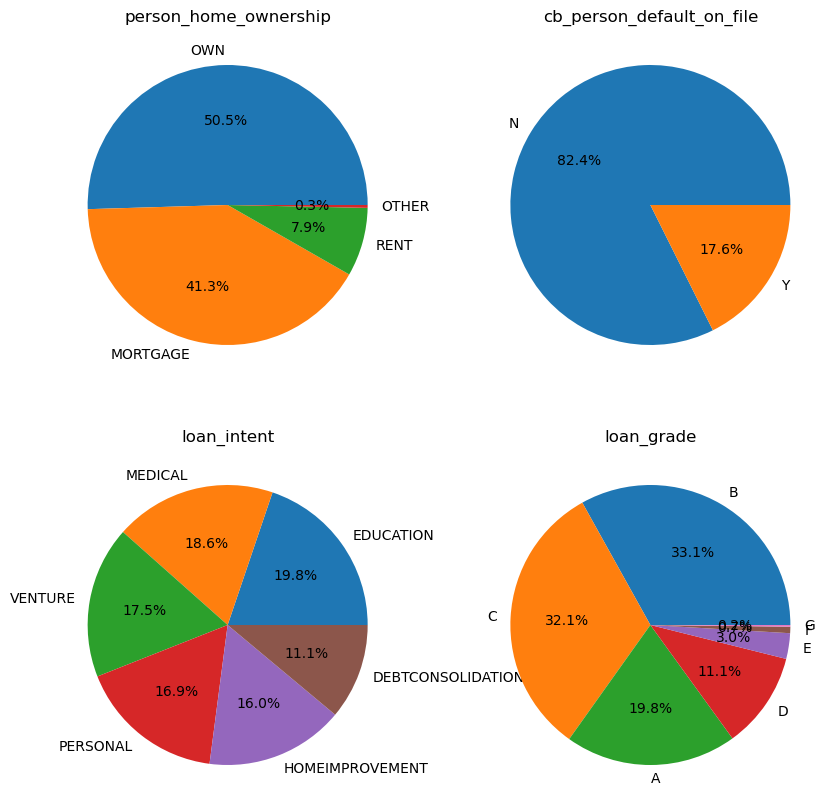

In [20]:
# Pie plot of Value counts in the feature Person_home_ownership,loan_intent,cb_person_default_on_file and loan_grade
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(221)
line1 = plt.pie(df_2["person_home_ownership"].value_counts(),labels = df_2["person_home_ownership"].unique(),autopct="%1.1f%%")
plt.title('person_home_ownership')
ax1 = fig.add_subplot(223)
line2 = plt.pie(df_2["loan_intent"].value_counts(),labels = df_2["loan_intent"].unique(),autopct="%1.1f%%")
plt.title('loan_intent')
ax1 = fig.add_subplot(222)
line3 = plt.pie(df_2["cb_person_default_on_file"].value_counts(),labels = df_2["cb_person_default_on_file"].unique()
                ,autopct="%1.1f%%")
plt.title('cb_person_default_on_file')
ax1 = fig.add_subplot(224)
line4 = plt.pie(df_2["loan_grade"].value_counts(),labels = df_2["loan_grade"].unique(),autopct="%1.1f%%")
plt.title('loan_grade')
plt.show()

Targetting 4 Object Datatype feature which are person_home_ownership,loan_intent,loan_grade and cb_person_default_on_file.
We are checking for distribution of Data from Those Features.

Column Name -  person_home_ownership
- RENT = 16446 (7.9%)
- MORTGAGE = 13444 (41.3%)
- OWN = 2584 (50.5%)
- OTHER = 107 (0.3%)

Column Name -  loan_intent
- EDUCATION            = 6453 (19.8%)
- MEDICAL              = 6071 (18.6%)
- VENTURE              = 5719 (17.5%)
- PERSONAL             = 5521 (16.9%)
- DEBTCONSOLIDATION    = 5212 (11.1%)
- HOMEIMPROVEMENT      = 3605 (16.0%)

Column Name -  loan_grade
- A    = 10777 (19.8%)
- B    = 10451 (33.1%)
- C    = 6458  (32.1%)
- D    = 3626  (11.1%)
- E    =  964  (3.0%)
- F    =  241  (0.7%)
- G    =   64  (0.2%)

Column Name -  cb_person_default_on_file
- N    = 26836 (82.4%)
- Y    =  5745 (17.6%)

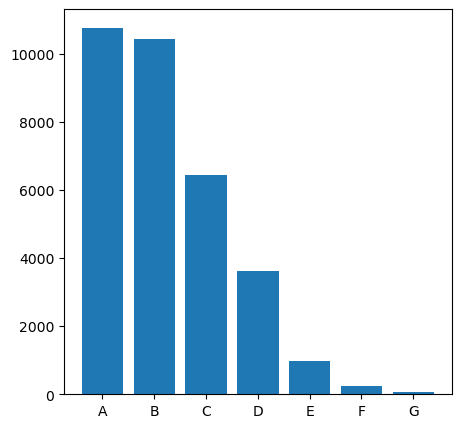

In [21]:
# bar graph of Value counts in the feature loan-grade
dict1 = df_2["loan_grade"].value_counts().to_dict()
x1 = list(dict1.keys())
y1 = list(dict1.values())
plt.figure(figsize=(5,5))
plt.bar(x1,y1)
plt.show()

- Desciding Encoding Types

In [22]:
# Checking for any sequence is the object columns so we can select encoding techniques.
cols = df_2.select_dtypes(include="object").columns.to_list()
for feature in cols:
    print("Column Name - ",feature)
    print(df_2[feature].unique())
    print()

Column Name -  person_home_ownership
['OWN' 'MORTGAGE' 'RENT' 'OTHER']

Column Name -  loan_intent
['EDUCATION' 'MEDICAL' 'VENTURE' 'PERSONAL' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']

Column Name -  loan_grade
['B' 'C' 'A' 'D' 'E' 'F' 'G']

Column Name -  cb_person_default_on_file
['N' 'Y']



Here we can clearely see there is no any precedence or sequence in the person_home_ownership, 
loan_intent and loan_grade Features so we have to use either get_dummies() or OneHotEncoding Technique.

- Features for OneHotEncoding / Get Dummies - person_home_ownership, loan_intent, loan_grade

Here we can clearely see there is precedence or sequence in the cb_person_default_on_file
Feature so we have to use either replace() or Ordinal Encoding Technique.

- Features for OrdinalEncoding / replace - cb_person_default_on_file

As there are numerical values in the loan_status feature i.e Target Feature so we doesnt require need of Label Encoding Technique

- Outliers Detection

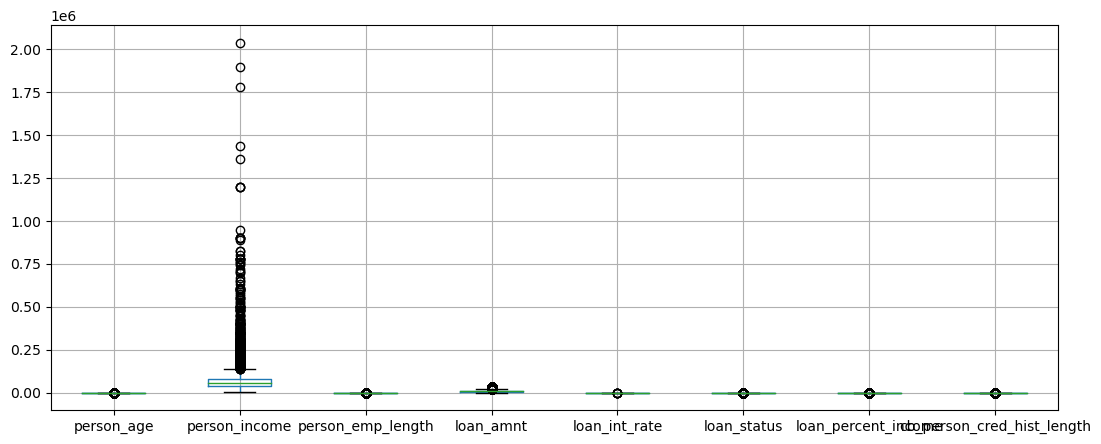

In [23]:
# Here we can see there ae outliers in the every feature
plt.figure(figsize=(13,5))
df_2.boxplot()
plt.show()

Here we can clearly see the outliers in the each and every column so we have to check for each columns 
Separately. We have to check especially for `person_income` feature because there are extreme outliers in that
feature ata first glance.

<AxesSubplot:xlabel='person_age'>

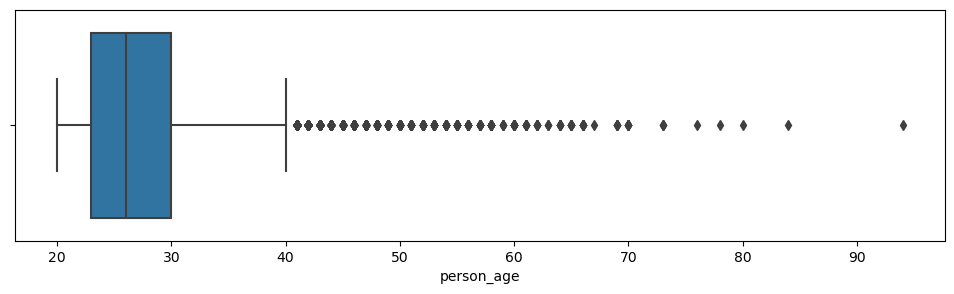

In [24]:
# Checking of outliers in person_age Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["person_age"])

In [25]:
# Count of outliers in person_age by using Z-score method
z = zscore(df_2["person_age"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in person_age - {len(z1)}")

Count of Outliers in person_age - 553


Here we can say practically age more than 100 is not possible so those are outliers. Values present in 
the feature `person_age` are now not trated as outliers because commonly persons live between 0 to 100 
years. We have dealed Extreme outliers before.

<AxesSubplot:xlabel='person_income'>

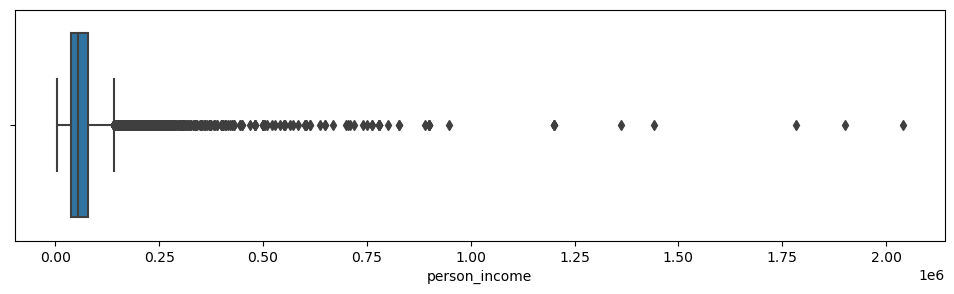

In [26]:
# Checking of outliers in person_income Feature, we can see there is one extreme outlier
# we are not considering 558 are outliers because person can live upto 120 years.
plt.figure(figsize=(12,3))
sns.boxplot(df_2["person_income"])

In [27]:
# Count of outliers in person_income by using Z-score method
z = zscore(df_2["person_income"]).to_list()
z2 = []
for i in z:
    if i > 3 or i <-3:
        z2.append(i)
print(f"Count of Outliers in person_income - {len(z2)}")

Count of Outliers in person_income - 355


In [28]:
# Count of Outliers using iqr method to crosscheck the above result.
q1 = df_2["person_income"].quantile(0.25)
q3 = df_2["person_income"].quantile(0.75)
iqr = q3 - q1
upper_tail = q3 + 1.5 * iqr
lower_tail = q1 - 1.5 * iqr
print(f"Upper tail - {upper_tail}\nLower tail - {lower_tail}")
count = df_2.loc[(df_2["person_income"] > upper_tail) | (df_2["person_income"] < lower_tail)].shape[0]
print(f"Count of Outliers in person_income - {count}")

Upper tail - 140250.0
Lower tail - -22550.0
Count of Outliers in person_income - 1480


`person_income` in this column there are 1480 outliers by IQR method and there are also extreme outliers in this Feature.

<AxesSubplot:xlabel='person_emp_length'>

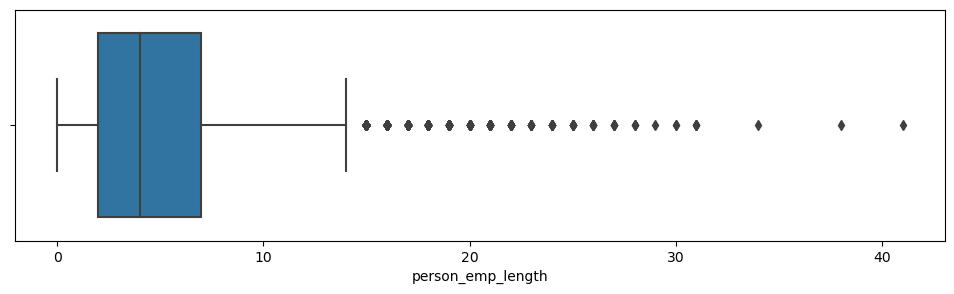

In [29]:
# Checking of outliers in person_emp_length Feature,we can see there is one extreme outlier.
plt.figure(figsize=(12,3))
sns.boxplot(df_2["person_emp_length"])

In [30]:
# Count of outliers in person_emp_length by using Z-score method, here z-score is showing
z = zscore(df_2["person_emp_length"]).to_list()
z1 = []
for i in z:
    if i > 3 or i < -3:
        z1.append(i)
print(f"Count of Outliers in person_emp_length - {len(z1)}")

Count of Outliers in person_emp_length - 0


In [31]:
# Count of Outliers using iqr method to crosscheck the above result.
q1 = df_2["person_emp_length"].quantile(0.25)
q3 = df_2["person_emp_length"].quantile(0.75)
iqr = q3 - q1
upper_tail = q3 + 1.5 * iqr
lower_tail = q1 - 1.5 * iqr
print(f"Upper tail - {upper_tail}\nLower tail - {lower_tail}")
count = df_2.loc[(df_2["person_emp_length"] > upper_tail) | (df_2["person_emp_length"] < lower_tail)].shape[0]
print(f"Count of Outliers in person_emp_length - {count}")

Upper tail - 14.5
Lower tail - -5.5
Count of Outliers in person_emp_length - 851


We have Dropped Outliers in this Feature Earlier at the start So according to Z-Score method. This Column is Free from outliers.

<AxesSubplot:xlabel='loan_amnt'>

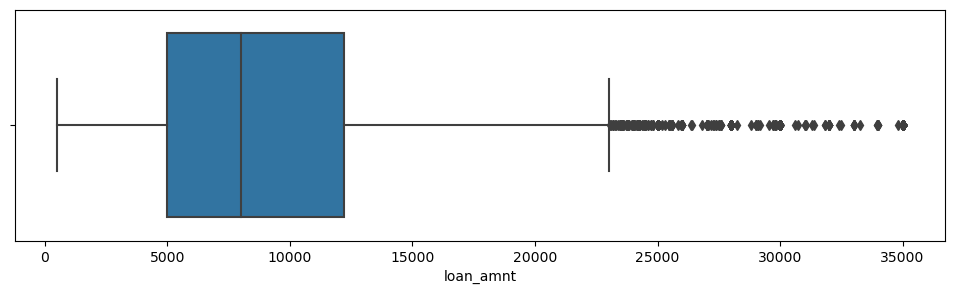

In [32]:
# Checking of outliers in loan_amnt Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["loan_amnt"])

In [33]:
# Count of outliers in loan_amnt by using Z-score method
z = zscore(df_2["loan_amnt"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in loan_amnt - {len(z1)}")

Count of Outliers in loan_amnt - 336


<AxesSubplot:xlabel='loan_int_rate'>

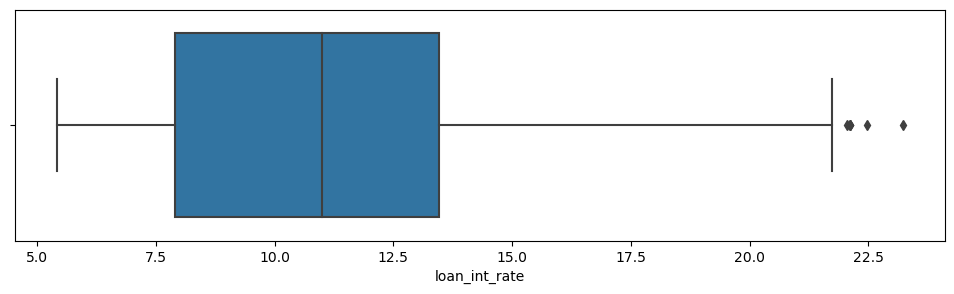

In [34]:
# Checking of outliers in loan_int_rate Feature, Too few outliers in data.
plt.figure(figsize=(12,3))
sns.boxplot(df_2["loan_int_rate"])

In [35]:
# Count of outliers in loan_int_rate by using Z-score method
z = zscore(df_2["loan_int_rate"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in loan_int_rate - {len(z1)}")

Count of Outliers in loan_int_rate - 0


In [37]:
# Count of Outliers using iqr method to crosscheck the above result.
q1 = df_2["loan_int_rate"].quantile(0.25)
q3 = df_2["loan_int_rate"].quantile(0.75)
iqr = q3 - q1
upper_tail = q3 + 1.5 * iqr
lower_tail = q1 - 1.5 * iqr
print(f"Upper tail - {upper_tail}\nLower tail - {lower_tail}")
count = df_2.loc[(df_2["loan_int_rate"] > upper_tail) | (df_2["loan_int_rate"] < lower_tail)].shape[0]
print(f"Count of Outliers in person_income - {count}")

Upper tail - 21.825000000000003
Lower tail - -0.45500000000000007
Count of Outliers in person_income - 6


So according to Z-Score method there are no Outliers in the `loan_int_rate` Feature. We can also See visually there are few outliers but which are to close to the Upper tail.

<AxesSubplot:xlabel='loan_percent_income'>

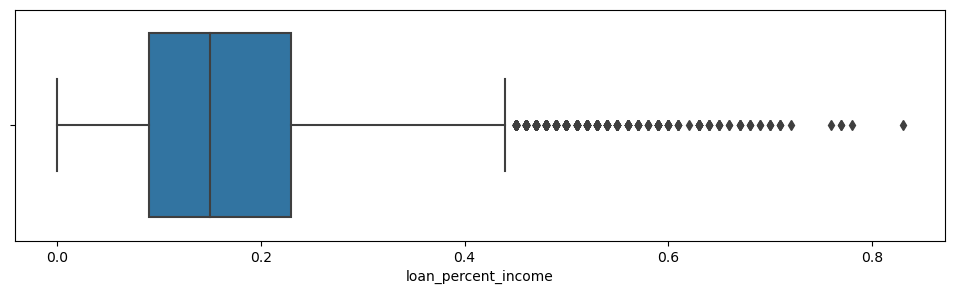

In [38]:
# Checking of outliers in loan_percent_income Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["loan_percent_income"])

In [39]:
# Count of outliers in loan_percent_income by using Z-score method
z = zscore(df_2["loan_percent_income"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in loan_percent_income - {len(z1)}")

Count of Outliers in loan_percent_income - 335


<AxesSubplot:xlabel='cb_person_cred_hist_length'>

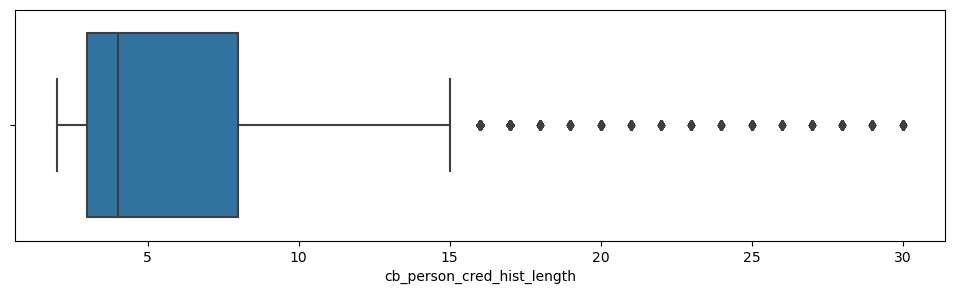

In [40]:
# Checking of outliers in cb_person_cred_hist_length Feature
plt.figure(figsize=(12,3))
sns.boxplot(df_2["cb_person_cred_hist_length"])

In [41]:
# Count of outliers in cb_person_cred_hist_length by using Z-score method
z = zscore(df_2["cb_person_cred_hist_length"]).to_list()
z1 = []
for i in z:
    if i > 3 or i <-3:
        z1.append(i)
print(f"Count of Outliers in cb_person_cred_hist_length - {len(z1)}")

Count of Outliers in cb_person_cred_hist_length - 283


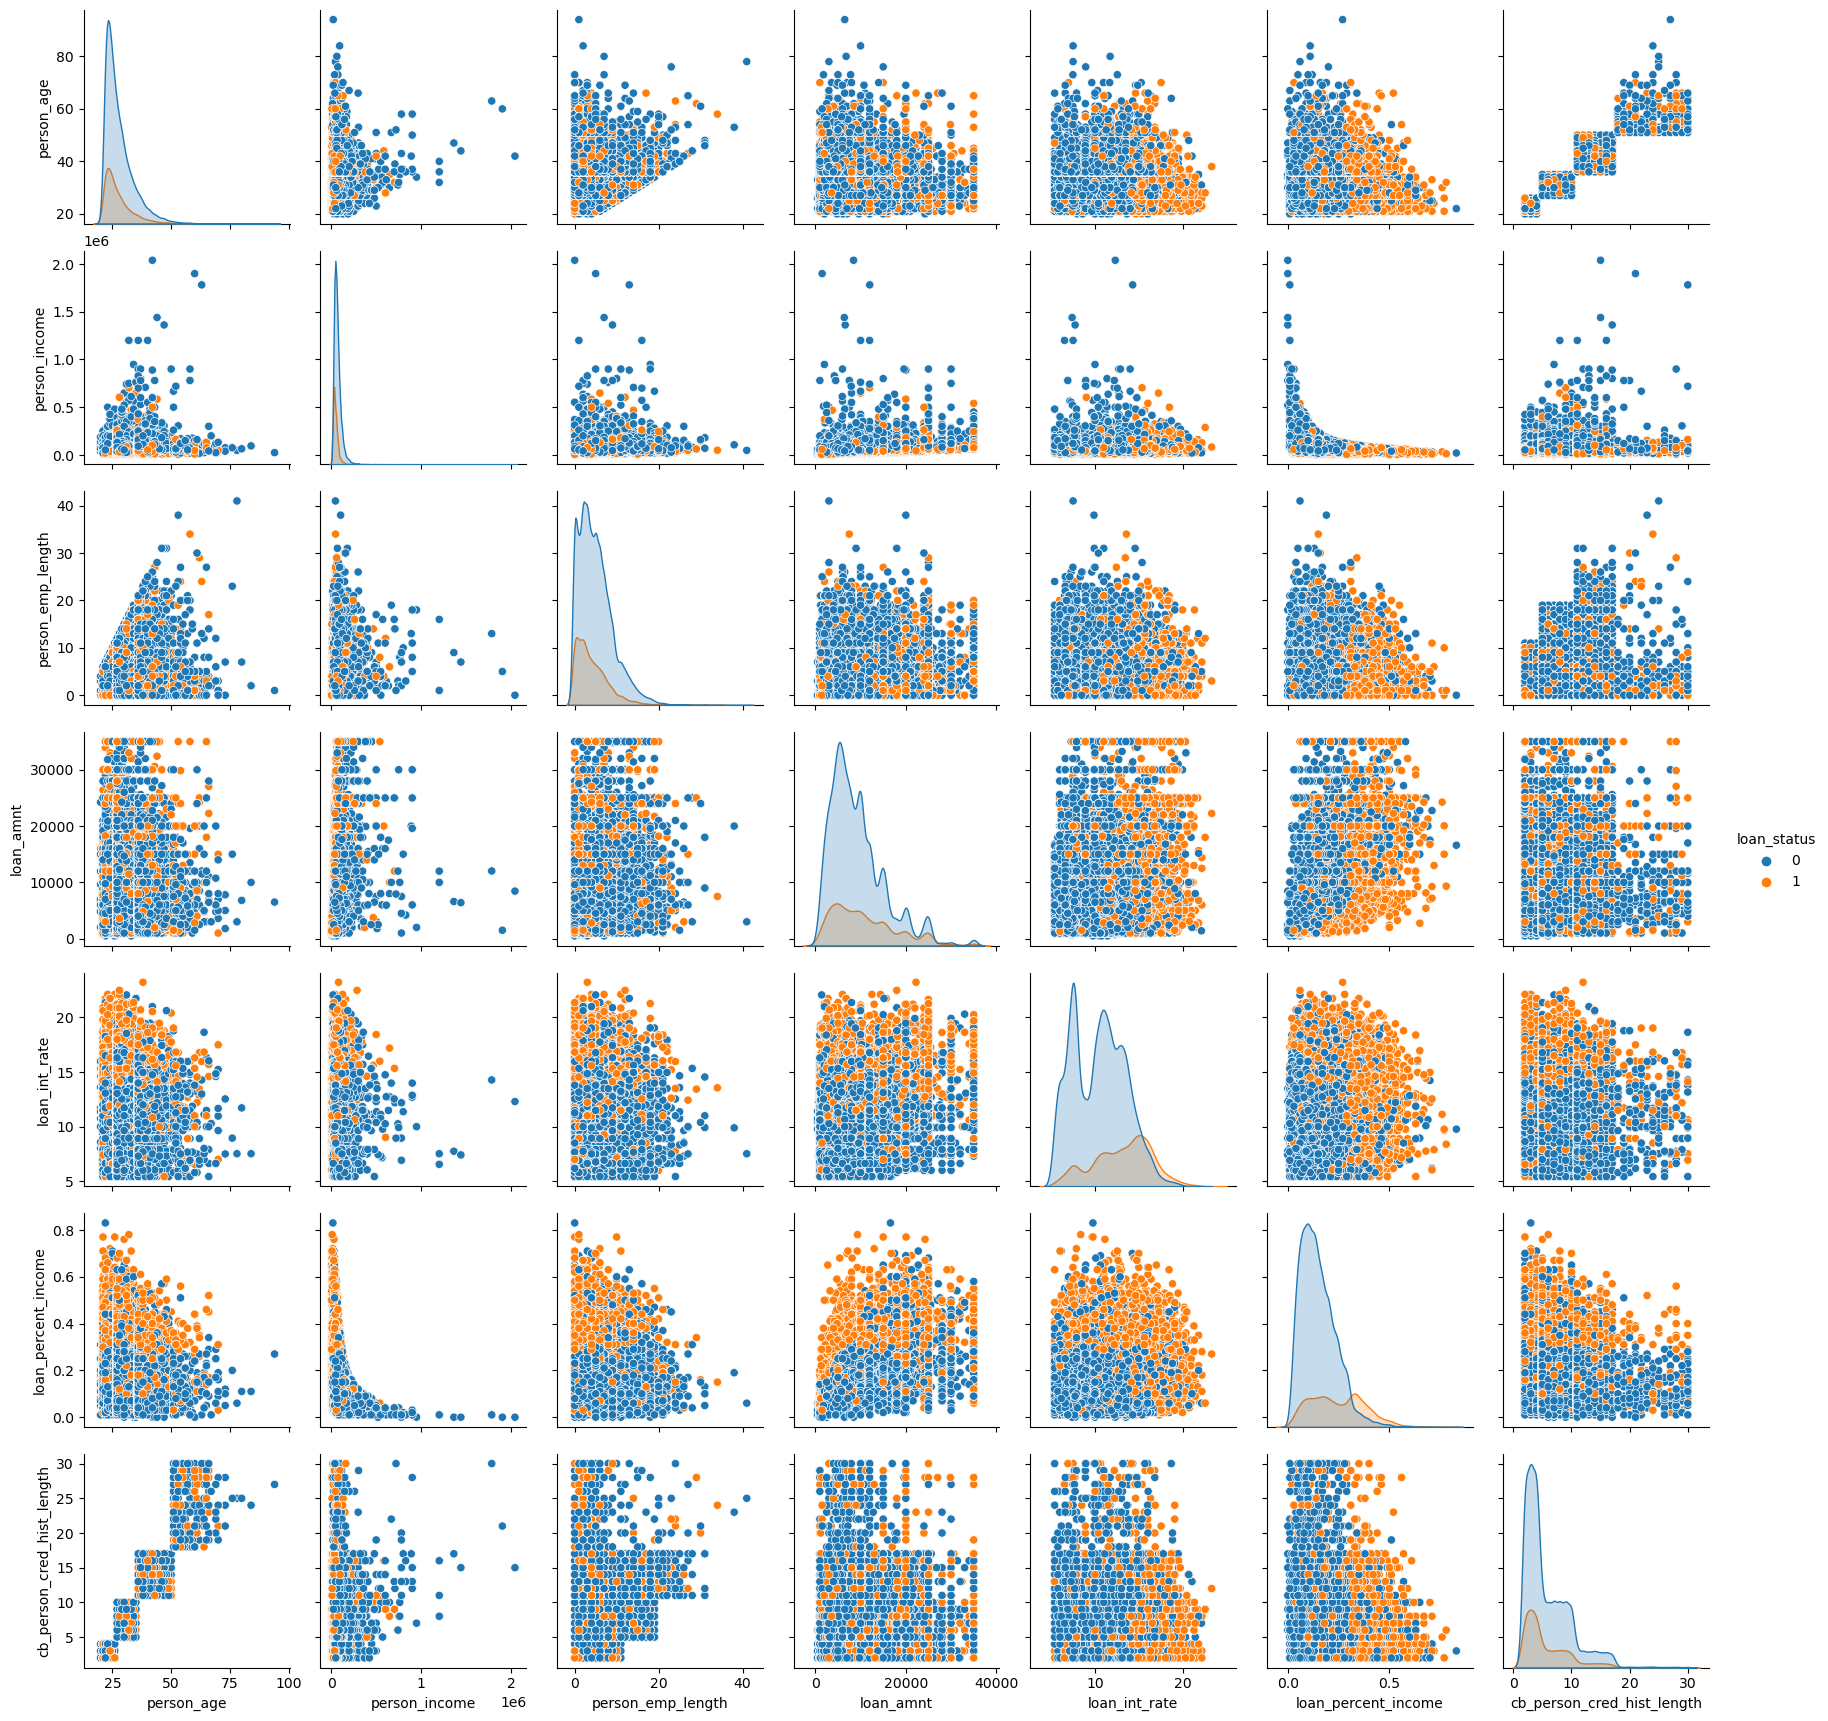

In [42]:
# Pairplot for Distribution
sns.pairplot(df_2,hue="loan_status")

- Correlation with Target Feature

In [43]:
# Checking for correlation of independent feature with dependent features and and we are not getting good correlation.
df_2.corr()

person_age  person_income  person_emp_length  \
person_age                    1.000000       0.140497           0.172554   
person_income                 0.140497       1.000000           0.154746   
person_emp_length             0.172554       0.154746           1.000000   
loan_amnt                     0.051751       0.317497           0.110993   
loan_int_rate                 0.011966      -0.001121          -0.058263   
loan_status                  -0.020687      -0.168485          -0.085966   
loan_percent_income          -0.041587      -0.294558          -0.058559   
cb_person_cred_hist_length    0.878094       0.123049           0.149404   

                            loan_amnt  loan_int_rate  loan_status  \
person_age                   0.051751       0.011966    -0.020687   
person_income                0.317497      -0.001121    -0.168485   
person_emp_length            0.110993      -0.058263    -0.085966   
loan_amnt                    1.000000       0.146803     0.105240   
loan_int_rate                0.146803       1.000000     0.335092   
loan_status                  0.105240       0.335092     1.000000   
loan_percent_income          0.572420       0.120218     0.379250   
cb_person_cred_hist_length   0.042240       0.016656    -0.015472   

                            loan_percent_income  cb_person_cred_hist_length  
person_age                            -0.041587                    0.878094  
person_income                         -0.294558                    0.123049  
person_emp_length                     -0.058559                    0.149404  
loan_amnt                              0.572420                    0.042240  
loan_int_rate                          0.120218                    0.016656  
loan_status                            0.379250                   -0.015472  
loan_percent_income                    1.000000                   -0.031447  
cb_person_cred_hist_length            -0.031447                    1.000000

In [44]:
# Checking for correlation
df2 = df_2.corr().iloc[5,:].to_frame().T
df2

person_age  person_income  person_emp_length  loan_amnt  \
loan_status   -0.020687      -0.168485          -0.085966    0.10524   

             loan_int_rate  loan_status  loan_percent_income  \
loan_status       0.335092          1.0              0.37925   

             cb_person_cred_hist_length  
loan_status                   -0.015472

<AxesSubplot:>

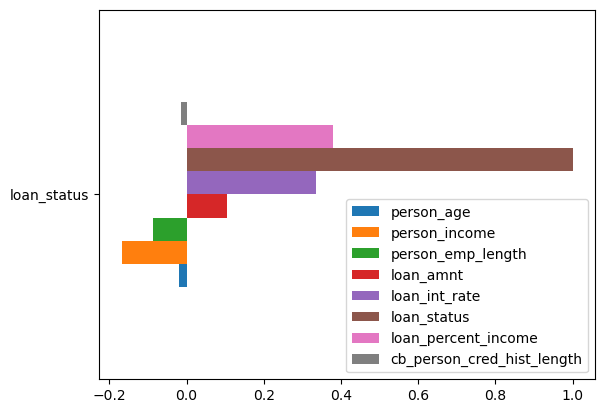

In [45]:
# bar plot of correlation of Loans status feature with respect to all independent features. 
df2.plot(kind="barh")

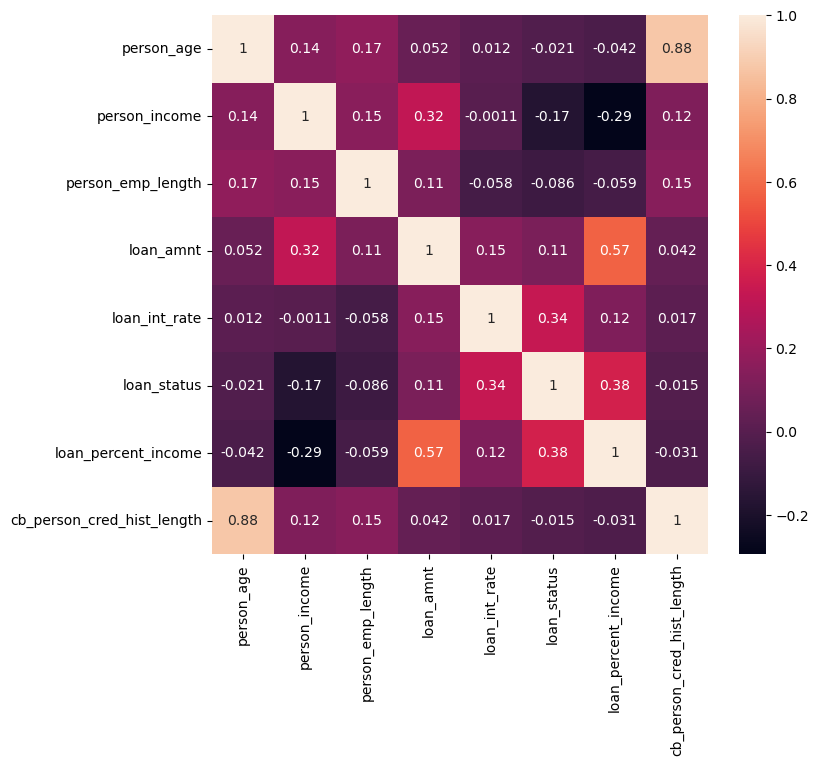

In [46]:
# Heatmap for correlation Values
plt.figure(figsize=(8,7))
sns.heatmap(df_2.corr(),annot=True)
plt.show()

Range of Good correlation/Predictors is -0.7 to -1 for negative correlation and 0.7 to 1 for positive
correlation. from above table,heatmap and horrizontal Bar graph there is no one feature which is best
Describing the target Feature and almost all features having Worst correlation. which is in between -0.3 to 0.3.
We can also say that -

- `person_age` is highly overall correlated with `cb_person_cred_hist_length` 
- `loan_amnt` is highly overall correlated with `loan_percent_income`
- `loan_int_rate` is highly overall correlated with `loan_grade`
- `loan_percent_income` is highly overall correlated with `loan_amnt` 
- `cb_person_cred_hist_length` is highly overall correlated with `person_age` 
- `loan_grade` is highly overall correlated with `loan_int_rate` 
- `cb_person_default_on_file` is highly overall correlated with `loan_int_rate`

- VIF (Variance Inflation Factor)

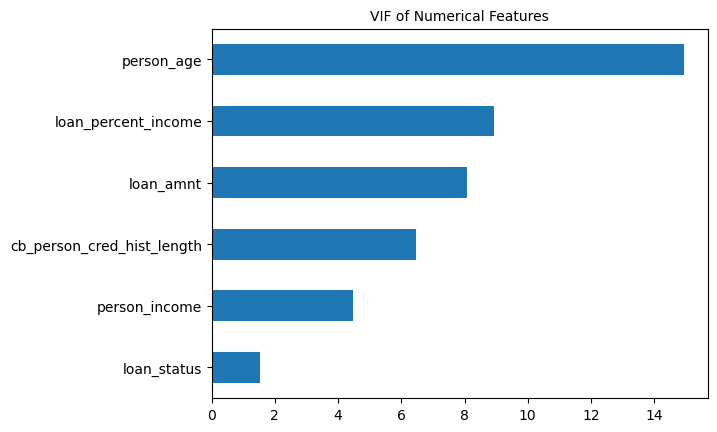

In [47]:
# Checking for relation between independent features. Here im dropping Features having null values
x = df_2.select_dtypes(exclude="object").drop(["loan_int_rate","person_emp_length"],axis=1)
vif_list = []
for i in range(x.shape[1]):
    vif = variance_inflation_factor(x.to_numpy(),i)
    vif_list.append(vif)
x1 = pd.Series(vif_list,index=x.columns)
x1.sort_values().plot(kind="barh")
plt.title("VIF of Numerical Features",fontsize=10)
plt.show()

Variance inflation factors range is 0 to infinity. 0 to 5 vif score it suggests that there is no correlation between other independent features. If VIF sore is more than 5 then we cut off that feature but in this case most of the features are above vif range so we are not removing any feature.

### - Status of Target Feature

First of all We dont require label encoding beacuse target column is actually in numerical datatype. In this case 0 is Non Default Loan Status and 1 is Default Loan Status.

In [48]:
# Checking for Value counts of loan_status feature
df_2["loan_status"].value_counts()

0    25467
1     7107
Name: loan_status, dtype: int64

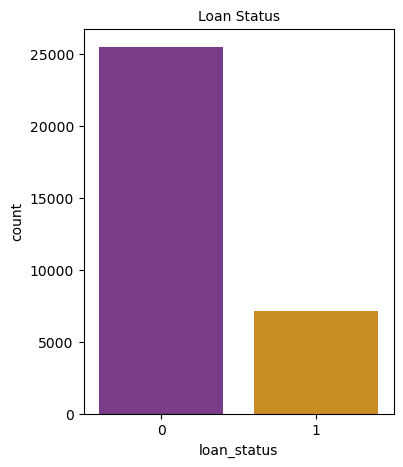

In [49]:
# Countplot of loan Status Feature
plt.figure(figsize=(4,5))
sns.countplot(df_2["loan_status"], palette='CMRmap')
plt.title("Loan Status",fontsize=10)
plt.show()

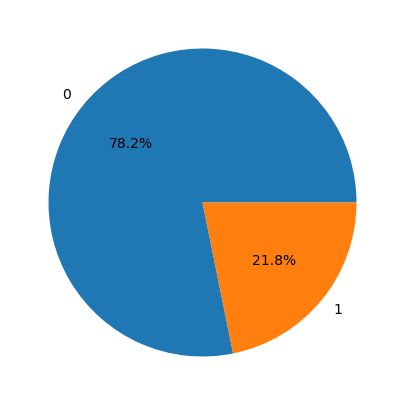

In [50]:
# pie of loan Status Feature so we can check distribution.
plt.figure(figsize=(5,5))
plt.pie(df_2["loan_status"].value_counts(),labels=df_2["loan_status"].unique()
        ,autopct="%1.1f%%")
plt.show()

So here we also got to know that there is bias in the categories so we have to perform sampling on it. Major category contains 78.2 percent of data in the Non Default loan Status category and minor category contains 21.8 percent data in Default loan Status Category.

Number of default cases: 6463
This is equivalent to 21.94% of the total loans

Number of non-defualt cases: 22996
This is equivalent to 78.06% of the total loans

- EDA Report using Pandas Profilling

In [ ]:
# Creating pandas Profiling Report
pf = pandas_profiling.ProfileReport(df_2)
pf.to_widgets()

In [ ]:
# Saving Pandas Profilling Report in the html format.
pf.to_file("EDA Report.html")

### 4) Making Hypothesis for Testing

Defining Hypothesis features wise by taking consideration the insights of above EDA part - 

#### person_age -                 

- More defaults for the younger peoples

#### person_income -

- People who defult have less income than people who have not default

#### person_home_ownership -

- Mortgage have more cases of default followed by rent and own

#### person_emp_length - 

- There are fewer people of default after long employment term

#### loan_intent -

- There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc.
- least cases of default for venture

#### loan_grade -

- The higher the grade there are fewer cases of default

#### loan_amnt -

- Median of ammount for non default is lower than median for default.

#### loan_int_rate - 

- Higher the intrest rate there higher defaults.

#### loan_percent_income -

- People who allocate higher percentage of income to the loan tend to default more than people who allocate less.

#### cb_person_default_on_file - 

- There are more cases of default those have default on file

#### cb_person_cred_hist_length -

- There are fewer cases of default those have higher credit history length.

## Hypothesis Testing

### Univariate Analysis -

#### Numerical Variables - 

In [51]:
# creating a dataset for numerical attributes/features
num = df_2.select_dtypes(include=['int64', 'float64'])
num.head()

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   
5          21           9900                2.0       2500           7.14   

   loan_status  loan_percent_income  cb_person_cred_hist_length  
1            0                 0.10                           2  
2            1                 0.57                           3  
3            1                 0.53                           2  
4            1                 0.55                           4  
5            1                 0.25                           2

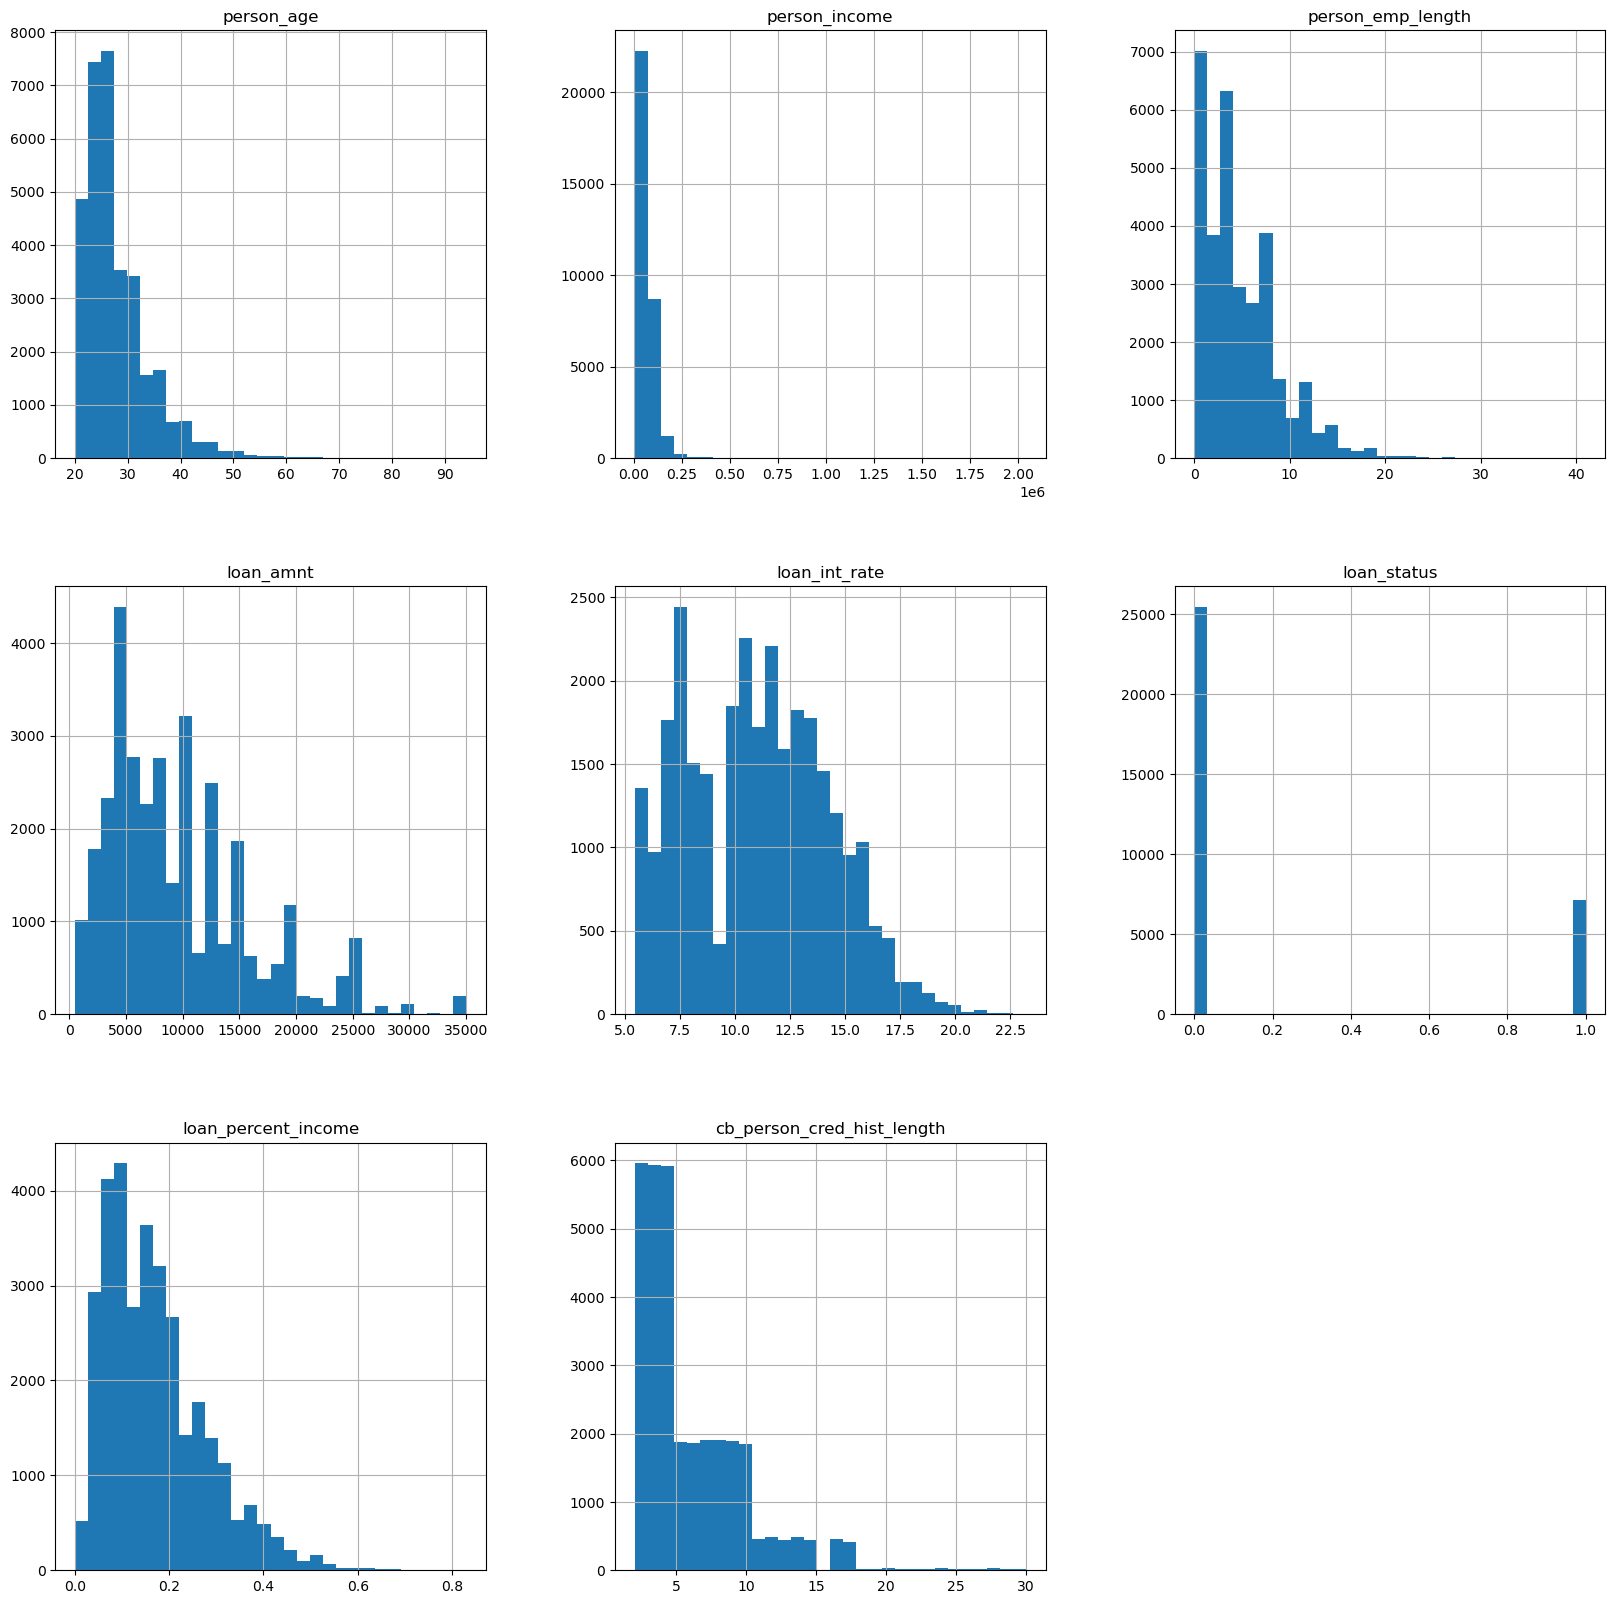

In [52]:
# plots a histogram for all numerical attributes
_ = num.hist(bins=30,figsize=(20,20))

As we can observe, there is no variable that presents a normal distribution. Note that here, we're only exploring the data, not making any handling or transformation.

#### Categorical Variables -

In [53]:
# Creating a dataset for Categorical Features -
catego = df_2.select_dtypes(include="object")
catego.head()

person_home_ownership loan_intent loan_grade cb_person_default_on_file
1                   OWN   EDUCATION          B                         N
2              MORTGAGE     MEDICAL          C                         N
3                  RENT     MEDICAL          C                         N
4                  RENT     MEDICAL          C                         Y
5                   OWN     VENTURE          A                         N

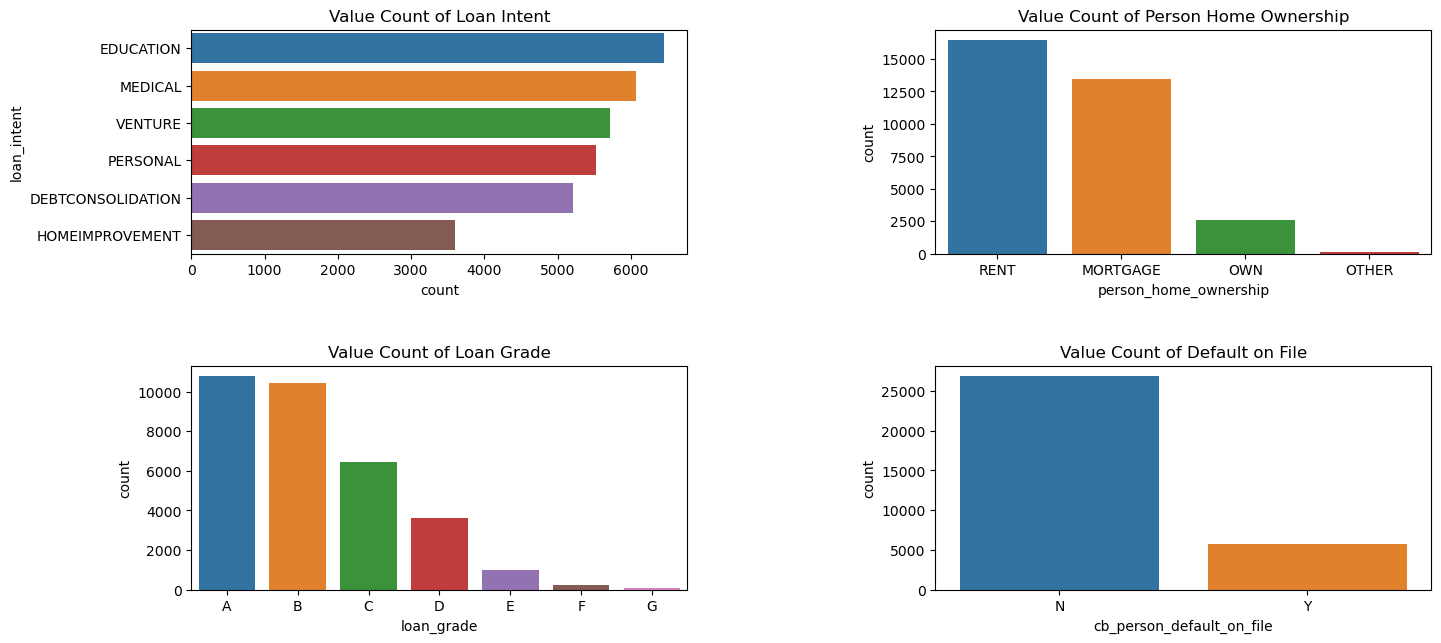

In [54]:
# Charts to show Distribution or count of unique values in Categorical featues
fig, ax = plt.subplots()
ax.figure.set_size_inches(16,16)

plt.subplot(4,2,1)
sns.countplot(y=catego["loan_intent"],order=catego["loan_intent"].value_counts().index)
plt.title("Value Count of Loan Intent")

plt.subplot(4,2,2)
sns.countplot(x=catego["person_home_ownership"],order=catego["person_home_ownership"].value_counts().index)
plt.title("Value Count of Person Home Ownership")

plt.subplot(4,2,3)
sns.countplot(x=catego["loan_grade"],order=catego["loan_grade"].value_counts().index)
plt.title("Value Count of Loan Grade")

plt.subplot(4,2,4)
sns.countplot(x=catego["cb_person_default_on_file"],order=catego["cb_person_default_on_file"].value_counts().index)
plt.title("Value Count of Default on File")

plt.subplots_adjust(hspace = 0.5)
plt.subplots_adjust(wspace = 0.5)
plt.show()

### Bivariate analysis - Hypothesis Validation

#### 1) More defaults for the younger peoples - 

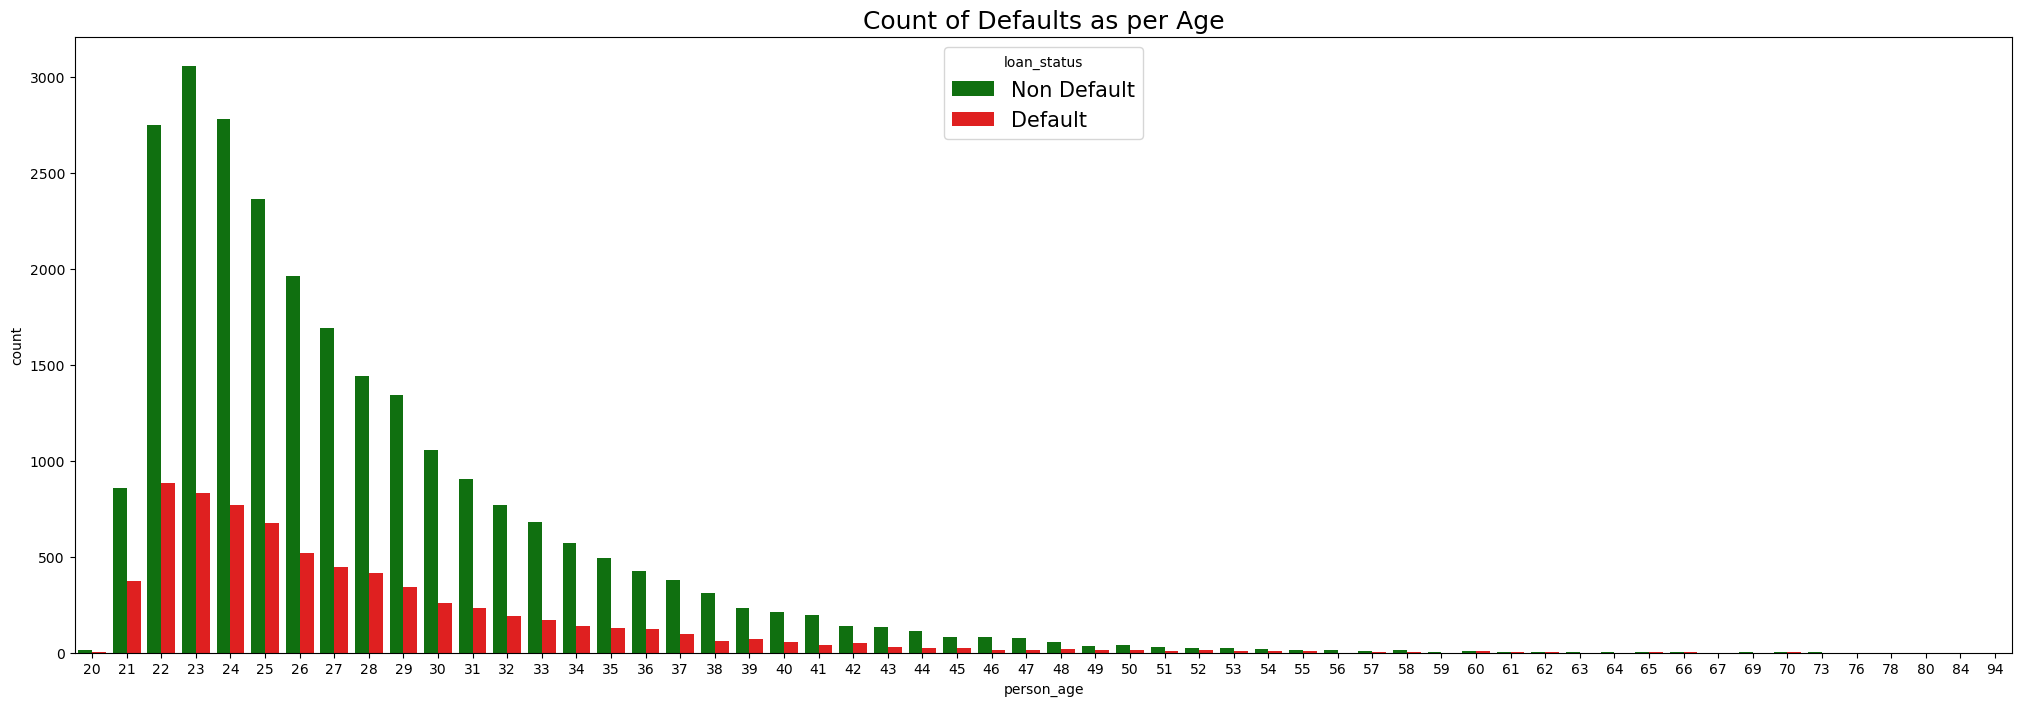

In [55]:
# count plot of Value counts in the loan Status feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(25,8)

sns.countplot(x=df_2["person_age"],hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Count of Defaults as per Age", fontsize=18)
plt.legend(title="loan_status",labels=["Non Default","Default"],fontsize=15)
plt.show()

As we can see there are more cases of Default up to the young age of 20 to 40. 
- Thus Hypothesis is `True`

#### 2) People who defults have less income than people who have not defaults - 

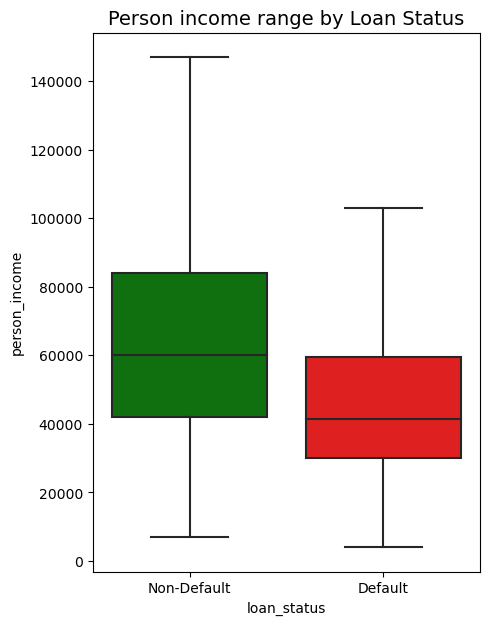

In [56]:
# Boxplot of person income and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["person_income"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Person income range by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [57]:
# Calulating Median values of person income
default = df_2[df_2["loan_status"] == 1]
nondefault = df_2[df_2["loan_status"] == 0]
print("Median of Loan Ammount for Defauts - ",default["person_income"].median())
print("Median of Loan Ammount for Non-Defauts - ",nondefault["person_income"].median())

Median of Loan Ammount for Defauts -  41496.0
Median of Loan Ammount for Non-Defauts -  60000.0


As we can see peoples who have defaults their median income(41496.0) is less than peoples who have not default(60000.0).

- Thus Hypothesis is `True`

#### 3) Mortgage have more cases of default followed by rent and own - 

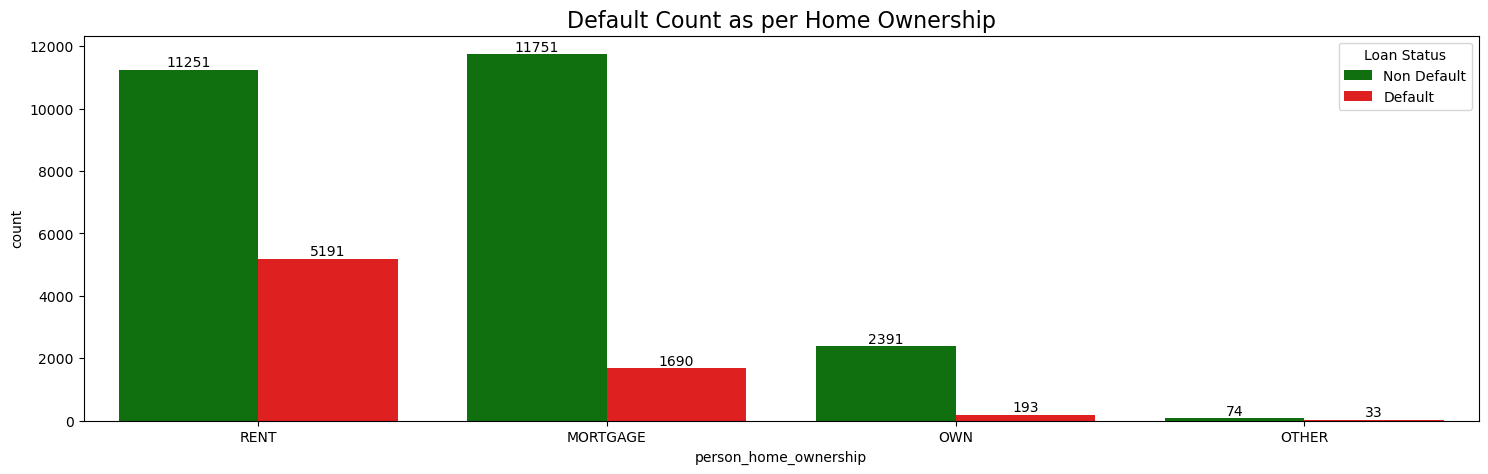

In [58]:
# countplot of Value counts in the person_home_ownership feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(18,5)

sns.countplot(x = df_2["person_home_ownership"],hue = df_2["loan_status"],
            order =df_2["person_home_ownership"].value_counts().index, palette=["g","r"])
ax.set_title("Default Count as per Home Ownership", fontsize= 16)
plt.legend(title="Loan Status", labels=["Non Default","Default"],title_fontsize=10)

for container in ax.containers:
    ax.bar_label(container)
    
plt.show()

As we can see Default cases for rent are more and then its followed by mortgage, own and other.
- Thus our Hypothesis is `False`

Here we are taking Alternate Hypothesis. Actually we found that there are more default on rent than mortgage. 

#### 4) There are fewer cases of default with long employment term -

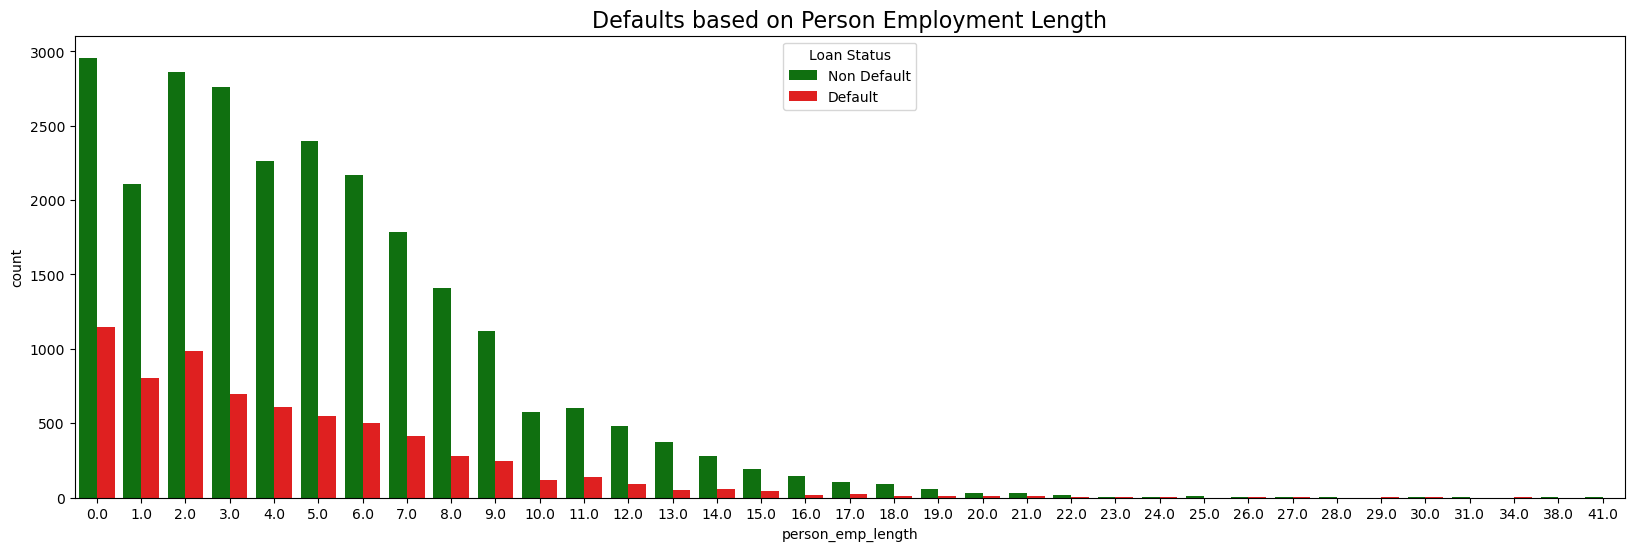

In [59]:
# countplot of Value counts in the person_emp_length feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["person_emp_length"],hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Defaults based on Person Employment Length", fontsize=16)
ax.legend(title="Loan Status", labels=["Non Default","Default"], fontsize=10)
plt.show()

we can see from the chart there are fewer cases of default with long employment length after 15 years.

- Thus our Hypothesis is `True`

#### 5) There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc. -

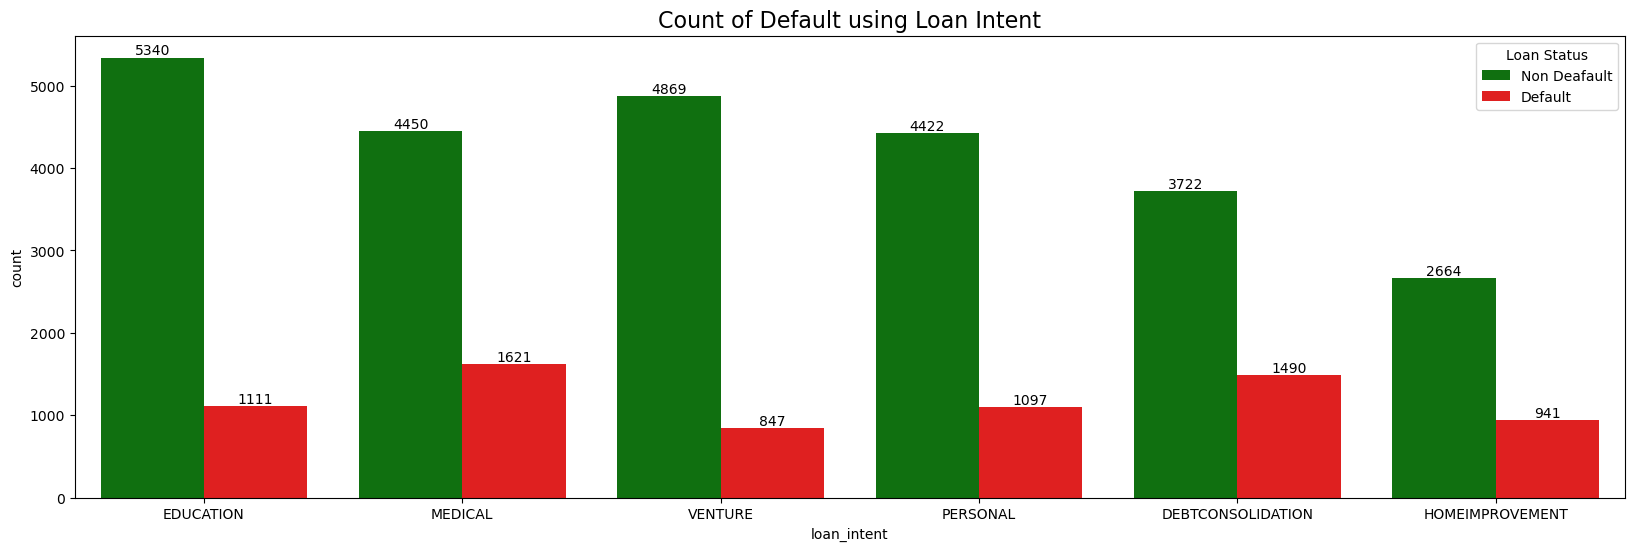

In [60]:
# countplot of Value counts in the loan_intent feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["loan_intent"], hue=df_2["loan_status"],palette=["g","r"],
             order=df_2["loan_intent"].value_counts().index)
ax.set_title("Count of Default using Loan Intent", fontsize = 16)
ax.legend(title="Loan Status", labels = ["Non Deafault","Default"], fontsize=10)
for container in ax.containers:
    ax.bar_label(container)

From above Graph There are more cases of Default for Medical Which is Followed by debt consolidation,
Education and personal case. 
- Thus Hypothesis is False.

#### 6) least cases of default for venture -

From above countplot we clearly see that Venture intent has least defaults.
- Thus Hypothesis is `True`

#### 7) The higher the grade there are fewer cases of default -

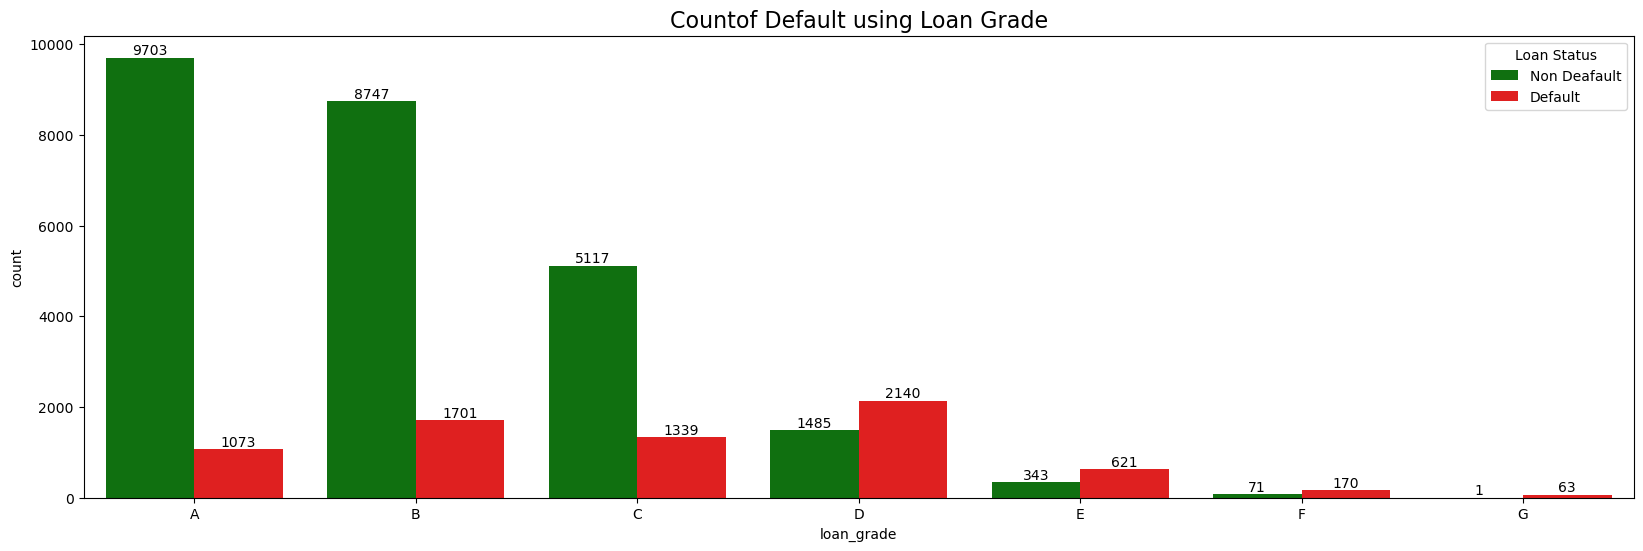

In [61]:
# countplot of Value counts in the loan_grade feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["loan_grade"], hue=df_2["loan_status"],palette=["g","r"],
             order=df_2["loan_grade"].value_counts().index)
ax.set_title("Countof Default using Loan Grade", fontsize = 16)
ax.legend(title="Loan Status", labels = ["Non Deafault","Default"], fontsize=10)
for container in ax.containers:
    ax.bar_label(container)
plt.show()

From above graph we see that there is loan grade D has highest default but now we cannot say there are higher 
grade then cases of defaults are less.
- Thus our Hypothesis is `False`

#### 8) Median of ammount for non default is lower than median for default -

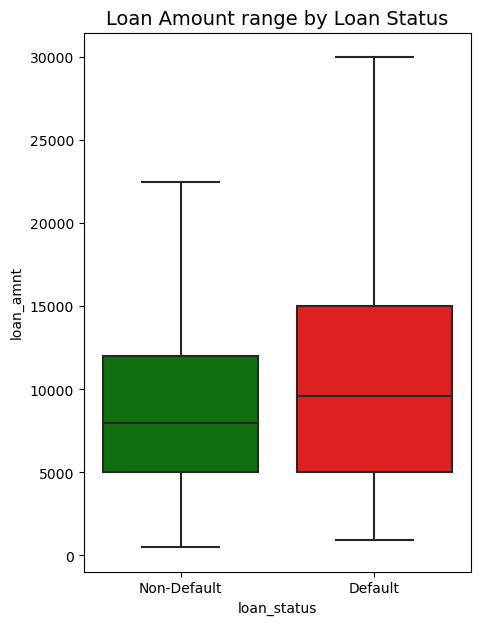

In [62]:
# Boxplot of person amount and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["loan_amnt"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Loan Amount range by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [63]:
print("Median of Loan Ammount for Defauts - ",default["loan_amnt"].median())
print("Median of Loan Ammount for Non-Defauts - ",nondefault["loan_amnt"].median())

Median of Loan Ammount for Defauts -  9600.0
Median of Loan Ammount for Non-Defauts -  8000.0


As we can see clearly median Values of Loan ammount according to loan status,Median loan ammount for defaults is Higher. 

Median of Loan Ammount for Defauts -  9600.0

Median of Loan Ammount for Non-Defauts -  8000.0

- Thus our Hypothesis is `True`

#### 9) Higher the intrest rate there are higher defaults -

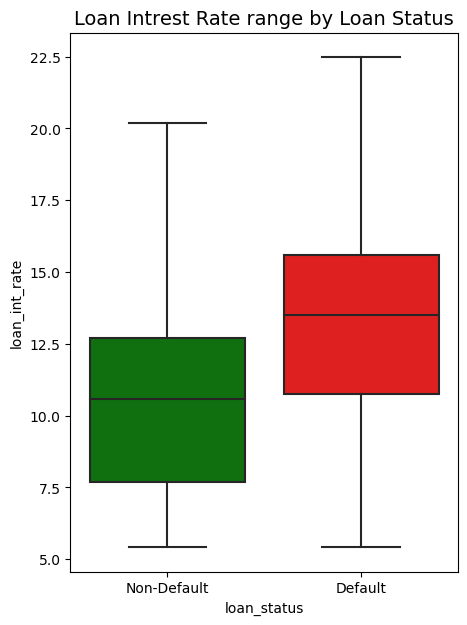

In [64]:
# Boxplot of Loan interest rate and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["loan_int_rate"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Loan Intrest Rate range by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [65]:
print("Median of Loan Intrest Rate for Defauts - ",default["loan_int_rate"].median())
print("Median of Loan Intrest Rate for Non-Defauts - ",nondefault["loan_int_rate"].median())

Median of Loan Intrest Rate for Defauts -  13.49
Median of Loan Intrest Rate for Non-Defauts -  10.59


From graph we can conclude median of interest rate is higher for defaults and lower for non defaults

Median of Loan Intrest Rate for Defauts -  13.49

Median of Loan Intrest Rate for Non-Defauts -  10.59

- Thus our Hypothesis is True.

#### 10) People who allocate higher percentage of income to the loan tend to default more than people who allocate less - 

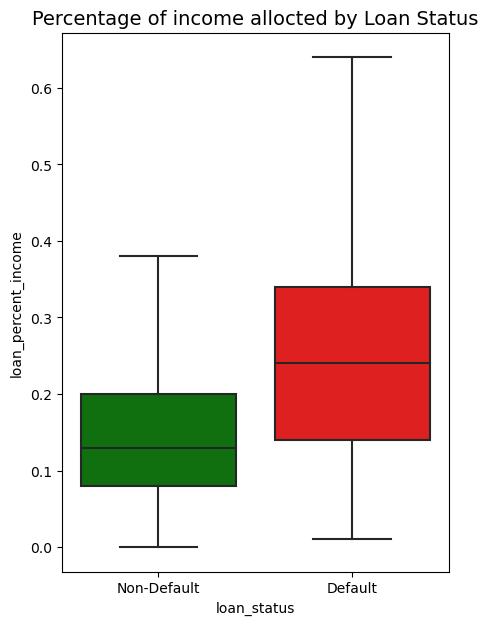

In [66]:
# Boxplot of Loan Percentage Income and loan Status
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,7)

sns.boxplot(y = df_2["loan_percent_income"], x= df_2["loan_status"],showfliers=False,palette=["g","r"])
ax.set_title("Percentage of income allocted by Loan Status", fontsize=14)
plt.xticks([0,1],["Non-Default","Default"])
plt.show()

In [67]:
print("Median of Loan Percent Income for Defauts - ",default["loan_percent_income"].median())
print("Median of Loan Percent Income for Non-Defauts - ",nondefault["loan_percent_income"].median())

Median of Loan Percent Income for Defauts -  0.24
Median of Loan Percent Income for Non-Defauts -  0.13


From belove values of median of loan percent income and charts we say that people who allocate higher percent of income 
to loan they will tend to default more than people who allocate less.

Median of Loan Percent Income for Defauts -  0.24

Median of Loan Percent Income for Non-Defauts -  0.13

- Thus our Hypothesis is `True`

#### 11) There are more cases of default those have default on file -

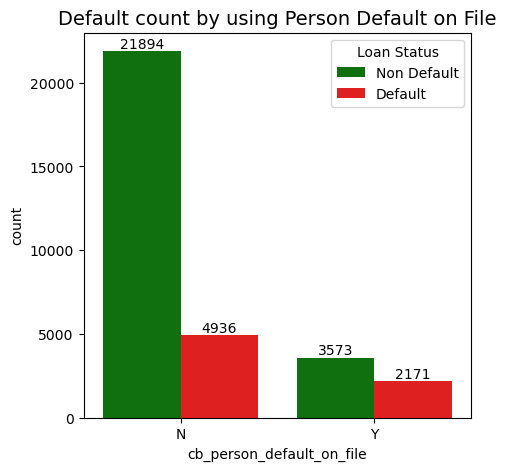

In [68]:
# Countplot of Value counts in person defaults on file feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(5,5)

sns.countplot(x = df_2["cb_person_default_on_file"], hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Default count by using Person Default on File", fontsize=14)
ax.legend(title="Loan Status", labels=["Non Default","Default"], fontsize=10)
for container in ax.containers:
    ax.bar_label(container)

plt.show()

From graph we can conclude that persons who dont have default on file those have more defaults.
- Thus our Hypothesis is `False` 

#### 12) There are fewer cases of default those have higher credit history length - 

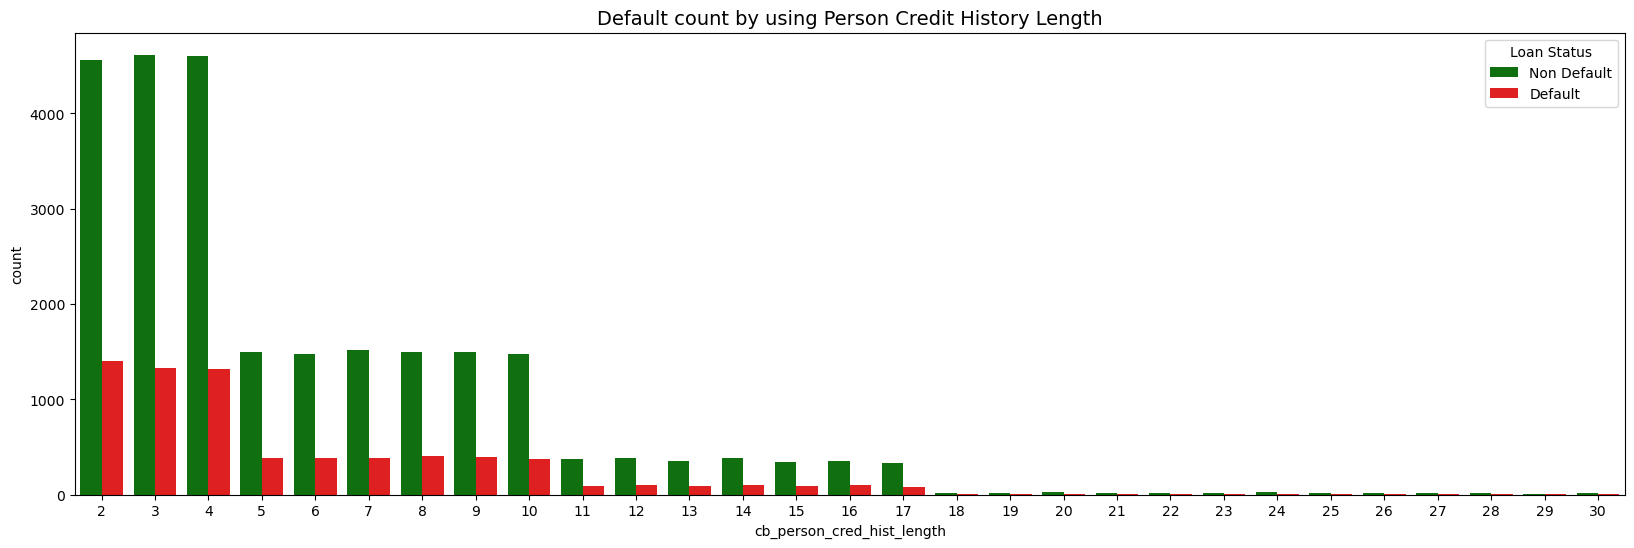

In [69]:
# Countplot of Value counts in person Credit history Length feature
fig, ax = plt.subplots()
ax.figure.set_size_inches(20,6)

sns.countplot(x = df_2["cb_person_cred_hist_length"], hue=df_2["loan_status"],palette=["g","r"])
ax.set_title("Default count by using Person Credit History Length", fontsize=14)
ax.legend(title="Loan Status", labels=["Non Default","Default"], fontsize=10)

plt.show()

As Observed, there are there are fewer cases of default for people having longer credit history length.
- Thus Hypothesis is `True`

### Making Table of Results on Hypothesis Testing -

In [70]:
pd.options.display.max_colwidth = 130
result = pd.DataFrame({"ID":np.arange(1,13),
                    "Hypothesis":["More defaults for the younger peoples.",
                                  "People who defult have less income than people who have not default.",
                                  "Mortgage have more cases of default followed by rent and own.",
                                  "There are fewer people of default after long employment term.",
                                  "There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc.",
                                  "Least cases of default for venture.",
                                  "The higher the grade there are fewer cases of default.",
                                  "Median of ammount for non default is lower than median for default.",
                                  "Higher the intrest rate there higher defaults.",
                                  "People who allocate higher percentage of income to the loan tend to default more than people who allocate less.",
                                  "There are more cases of default those have default on file.",
                                  "There are fewer cases of default those have higher credit history length."],
                   "Conclusion":["True","True","False","True","False","True","False","True","True","True","False","True"]})
result.set_index("ID",inplace=True)
result

Hypothesis  \
ID                                                                                                                        
1                                                                                More defaults for the younger peoples.   
2                                                  People who defult have less income than people who have not default.   
3                                                         Mortgage have more cases of default followed by rent and own.   
4                                                         There are fewer people of default after long employment term.   
5   There are more cases of default for personal intent which is followed by educational ,home improvment, medical etc.   
6                                                                                   Least cases of default for venture.   
7                                                                The higher the grade there are fewer cases of default.   
8                                                   Median of ammount for non default is lower than median for default.   
9                                                                        Higher the intrest rate there higher defaults.   
10      People who allocate higher percentage of income to the loan tend to default more than people who allocate less.   
11                                                          There are more cases of default those have default on file.   
12                                            There are fewer cases of default those have higher credit history length.   

   Conclusion  
ID             
1        True  
2        True  
3       False  
4        True  
5       False  
6        True  
7       False  
8        True  
9        True  
10       True  
11      False  
12       True

In [71]:
# Saving Data After EDA and Hypothesis testing in one File -
df_2.to_csv("Credit.csv",index=False)

### 4) Feature Engineering - 

In [ ]:
1) Handling of Missing Values
2) Encoding - Ordinal,replace,OneHot,get_dummies()

- Handling of Missing Values

In [72]:
# Reading CSV file
df_2 = pd.read_csv("Credit.csv")
df_2.head()

person_age  person_income person_home_ownership  person_emp_length  \
0          21           9600                   OWN                5.0   
1          25           9600              MORTGAGE                1.0   
2          23          65500                  RENT                4.0   
3          24          54400                  RENT                8.0   
4          21           9900                   OWN                2.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0   EDUCATION          B       1000          11.14            0   
1     MEDICAL          C       5500          12.87            1   
2     MEDICAL          C      35000          15.23            1   
3     MEDICAL          C      35000          14.27            1   
4     VENTURE          A       2500           7.14            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.10                         N                           2  
1                 0.57                         N                           3  
2                 0.53                         N                           2  
3                 0.55                         Y                           4  
4                 0.25                         N                           2

In [73]:
# Handling Missing Values in Feature person_emp_length by using Median after discussion with buisness experties.
df_2["person_emp_length"] = df_2["person_emp_length"].replace(np.nan,df_2["person_emp_length"].median())
df_2["loan_int_rate"] = df_2["loan_int_rate"].replace(np.nan,df_2["loan_int_rate"].median())

We can use several different functions like `mean()` and `mode()` to replace missing data. The goal here is to keep as much of our data as we can! It's also important to check the distribution of that feature to see if it changed.

In [74]:
df_2["person_emp_length"].median(),df_2["person_emp_length"].mean(),mode(df_2["person_emp_length"])[0][0]

(4.0, 4.760575919444956, 0.0)

In [75]:
df_2["loan_int_rate"].median(),df_2["loan_int_rate"].mean(),mode(df_2["loan_int_rate"])[0][0]

(10.99, 11.009469822556719, 10.99)

 - Encoding - Ordinal,replace,OneHot,get_dummies()

In [ ]:
# Features for OneHotEncoding / Get Dummies - person_home_ownership, loan_intent, loan_grade

In [76]:
# Applying OneHotEncoding on person_home_ownership Feature
one = OneHotEncoder()
array = one.fit_transform(df_2[["person_home_ownership"]]).toarray()
df2 = pd.DataFrame(array,columns=df_2["person_home_ownership"].unique())
df2.head()

OWN  MORTGAGE  RENT  OTHER
0  0.0       0.0   1.0    0.0
1  1.0       0.0   0.0    0.0
2  0.0       0.0   0.0    1.0
3  0.0       0.0   0.0    1.0
4  0.0       0.0   1.0    0.0

Once the new columns have been created using one-hot encoding, we can concatenate them with the numeric columns to create a new data frame which will be used throughout the rest of the course for predicting probability of default.

In [77]:
# Creating new df after one hot encoding
df1 = pd.concat([df_2,df2],axis=1)
df1.drop("person_home_ownership",axis=1,inplace=True)
df1.head()

person_age  person_income  person_emp_length loan_intent loan_grade  \
0          21           9600                5.0   EDUCATION          B   
1          25           9600                1.0     MEDICAL          C   
2          23          65500                4.0     MEDICAL          C   
3          24          54400                8.0     MEDICAL          C   
4          21           9900                2.0     VENTURE          A   

   loan_amnt  loan_int_rate  loan_status  loan_percent_income  \
0       1000          11.14            0                 0.10   
1       5500          12.87            1                 0.57   
2      35000          15.23            1                 0.53   
3      35000          14.27            1                 0.55   
4       2500           7.14            1                 0.25   

  cb_person_default_on_file  cb_person_cred_hist_length  OWN  MORTGAGE  RENT  \
0                         N                           2  0.0       0.0   1.0   
1                         N                           3  1.0       0.0   0.0   
2                         N                           2  0.0       0.0   0.0   
3                         Y                           4  0.0       0.0   0.0   
4                         N                           2  0.0       0.0   1.0   

   OTHER  
0    0.0  
1    0.0  
2    1.0  
3    1.0  
4    0.0

In [78]:
# Applying get_dummies function on loan_intent and loan_grade for Encoding
df = pd.get_dummies(df1,columns=["loan_intent","loan_grade"])
df.shape

(32574, 26)

In [79]:
# Checking for dataframe after get dummies operation.
df.head()

person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          21           9600                5.0       1000          11.14   
1          25           9600                1.0       5500          12.87   
2          23          65500                4.0      35000          15.23   
3          24          54400                8.0      35000          14.27   
4          21           9900                2.0       2500           7.14   

   loan_status  loan_percent_income cb_person_default_on_file  \
0            0                 0.10                         N   
1            1                 0.57                         N   
2            1                 0.53                         N   
3            1                 0.55                         Y   
4            1                 0.25                         N   

   cb_person_cred_hist_length  OWN  MORTGAGE  RENT  OTHER  \
0                           2  0.0       0.0   1.0    0.0   
1                           3  1.0       0.0   0.0    0.0   
2                           2  0.0       0.0   0.0    1.0   
3                           4  0.0       0.0   0.0    1.0   
4                           2  0.0       0.0   1.0    0.0   

   loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
0                              0                      1   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   

   loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
0                            0                    0                     0   
1                            0                    1                     0   
2                            0                    1                     0   
3                            0                    1                     0   
4                            0                    0                     0   

   loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  \
0                    0             0             1             0   
1                    0             0             0             1   
2                    0             0             0             1   
3                    0             0             0             1   
4                    1             1             0             0   

   loan_grade_D  loan_grade_E  loan_grade_F  loan_grade_G  
0             0             0             0             0  
1             0             0             0             0  
2             0             0             0             0  
3             0             0             0             0  
4             0             0             0             0

In [ ]:
# Features for OrdinalEncoding / replace - cb_person_default_on_file

In [80]:
df["cb_person_default_on_file"].value_counts().to_dict()

{'N': 26830, 'Y': 5744}

In [81]:
# Applying OrdinalEncoding on cb_person_default_on_file Feature
ordE = OrdinalEncoder(categories=[['N', 'Y']])
df["cb_person_default_on_file"] = ordE.fit_transform(df[["cb_person_default_on_file"]])
print(f"Unique values - ",df["cb_person_default_on_file"].unique())
df.head()

Unique values -  [0. 1.]


person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
0          21           9600                5.0       1000          11.14   
1          25           9600                1.0       5500          12.87   
2          23          65500                4.0      35000          15.23   
3          24          54400                8.0      35000          14.27   
4          21           9900                2.0       2500           7.14   

   loan_status  loan_percent_income  cb_person_default_on_file  \
0            0                 0.10                        0.0   
1            1                 0.57                        0.0   
2            1                 0.53                        0.0   
3            1                 0.55                        1.0   
4            1                 0.25                        0.0   

   cb_person_cred_hist_length  OWN  MORTGAGE  RENT  OTHER  \
0                           2  0.0       0.0   1.0    0.0   
1                           3  1.0       0.0   0.0    0.0   
2                           2  0.0       0.0   0.0    1.0   
3                           4  0.0       0.0   0.0    1.0   
4                           2  0.0       0.0   1.0    0.0   

   loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
0                              0                      1   
1                              0                      0   
2                              0                      0   
3                              0                      0   
4                              0                      0   

   loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
0                            0                    0                     0   
1                            0                    1                     0   
2                            0                    1                     0   
3                            0                    1                     0   
4                            0                    0                     0   

   loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  \
0                    0             0             1             0   
1                    0             0             0             1   
2                    0             0             0             1   
3                    0             0             0             1   
4                    1             1             0             0   

   loan_grade_D  loan_grade_E  loan_grade_F  loan_grade_G  
0             0             0             0             0  
1             0             0             0             0  
2             0             0             0             0  
3             0             0             0             0  
4             0             0             0             0

In [82]:
# Checking for correct Encoding Happened or Not. All Datatypes are numerical so we can now implement model.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32574 entries, 0 to 32573
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   person_age                     32574 non-null  int64  
 1   person_income                  32574 non-null  int64  
 2   person_emp_length              32574 non-null  float64
 3   loan_amnt                      32574 non-null  int64  
 4   loan_int_rate                  32574 non-null  float64
 5   loan_status                    32574 non-null  int64  
 6   loan_percent_income            32574 non-null  float64
 7   cb_person_default_on_file      32574 non-null  float64
 8   cb_person_cred_hist_length     32574 non-null  int64  
 9   OWN                            32574 non-null  float64
 10  MORTGAGE                       32574 non-null  float64
 11  RENT                           32574 non-null  float64
 12  OTHER                          32574 non-null 

In [83]:
# Checking for Statistics of dataset after Encoding.
df.describe()

person_age  person_income  person_emp_length     loan_amnt  \
count  32574.000000   3.257400e+04       32574.000000  32574.000000   
mean      27.718426   6.587848e+04           4.760576   9588.018051   
std        6.204987   5.253194e+04           3.981181   6320.249598   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12200.000000   
max       94.000000   2.039784e+06          41.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   32574.000000  32574.000000         32574.000000   
mean       11.009470      0.218180             0.170202   
std         3.081664      0.413017             0.106755   
min         5.420000      0.000000             0.000000   
25%         8.490000      0.000000             0.090000   
50%        10.990000      0.000000             0.150000   
75%        13.110000      0.000000             0.230000   
max        23.220000      1.000000             0.830000   

       cb_person_default_on_file  cb_person_cred_hist_length           OWN  \
count               32574.000000                32574.000000  32574.000000   
mean                    0.176337                    5.804108      0.412630   
std                     0.381112                    4.053873      0.492315   
min                     0.000000                    2.000000      0.000000   
25%                     0.000000                    3.000000      0.000000   
50%                     0.000000                    4.000000      0.000000   
75%                     0.000000                    8.000000      1.000000   
max                     1.000000                   30.000000      1.000000   

           MORTGAGE          RENT         OTHER  \
count  32574.000000  32574.000000  32574.000000   
mean       0.003285      0.079327      0.504758   
std        0.057220      0.270253      0.499985   
min        0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000   
50%        0.000000      0.000000      1.000000   
75%        0.000000      0.000000      1.000000   
max        1.000000      1.000000      1.000000   

       loan_intent_DEBTCONSOLIDATION  loan_intent_EDUCATION  \
count                   32574.000000           32574.000000   
mean                        0.160005               0.198041   
std                         0.366616               0.398530   
min                         0.000000               0.000000   
25%                         0.000000               0.000000   
50%                         0.000000               0.000000   
75%                         0.000000               0.000000   
max                         1.000000               1.000000   

       loan_intent_HOMEIMPROVEMENT  loan_intent_MEDICAL  loan_intent_PERSONAL  \
count                 32574.000000         32574.000000          32574.000000   
mean                      0.110671             0.186376              0.169430   
std                       0.313729             0.389415              0.375137   
min                       0.000000             0.000000              0.000000   
25%                       0.000000             0.000000              0.000000   
50%                       0.000000             0.000000              0.000000   
75%                       0.000000             0.000000              0.000000   
max                       1.000000             1.000000              1.000000   

       loan_intent_VENTURE  loan_grade_A  loan_grade_B  loan_grade_C  \
count         32574.000000  32574.000000  32574.000000  32574.000000   
mean              0.175477      0.330816      0.320747      0.198195   
std               0.380381      0.470514      0.466771      0.398646   
min               0.000000      0.000000      0.000000      0.000000   
25%             

### 5) Feature Selection - 

In [84]:
# Checking for Correlation of Each independent feature with target feature.
df.corr()

person_age  person_income  person_emp_length  \
person_age                       1.000000       0.140497           0.170688   
person_income                    0.140497       1.000000           0.155439   
person_emp_length                0.170688       0.155439           1.000000   
loan_amnt                        0.051751       0.317497           0.111820   
loan_int_rate                    0.011288      -0.001051          -0.052830   
loan_status                     -0.020687      -0.168485          -0.085613   
loan_percent_income             -0.041587      -0.294558          -0.058515   
cb_person_default_on_file        0.007223      -0.002524          -0.029010   
cb_person_cred_hist_length       0.878094       0.123049           0.147713   
OWN                              0.033171       0.235999           0.224239   
MORTGAGE                        -0.008463       0.011485          -0.015550   
RENT                            -0.000941      -0.044946           0.024216   
OTHER                           -0.031185      -0.209399          -0.232109   
loan_intent_DEBTCONSOLIDATION   -0.007887       0.004922          -0.001938   
loan_intent_EDUCATION           -0.093180      -0.016714          -0.038437   
loan_intent_HOMEIMPROVEMENT      0.076646       0.051513           0.030457   
loan_intent_MEDICAL              0.021567      -0.040464          -0.001851   
loan_intent_PERSONAL             0.034226       0.007845           0.009114   
loan_intent_VENTURE             -0.013820       0.003969           0.009924   
loan_grade_A                    -0.006086       0.009076           0.051037   
loan_grade_B                    -0.006838       0.006032          -0.004287   
loan_grade_C                     0.003697      -0.018025          -0.040105   
loan_grade_D                     0.009167      -0.014911          -0.009099   
loan_grade_E                     0.004217       0.016604          -0.017027   
loan_grade_F                     0.008825       0.018293          -0.011095   
loan_grade_G                     0.005142       0.009202           0.015206   

                               loan_amnt  loan_int_rate  loan_status  \
person_age                      0.051751       0.011288    -0.020687   
person_income                   0.317497      -0.001051    -0.168485   
person_emp_length               0.111820      -0.052830    -0.085613   
loan_amnt                       1.000000       0.139473     0.105240   
loan_int_rate                   0.139473       1.000000     0.319320   
loan_status                     0.105240       0.319320     1.000000   
loan_percent_income             0.572420       0.114420     0.379250   
cb_person_default_on_file       0.038875       0.477124     0.179002   
cb_person_cred_hist_length      0.042240       0.015724    -0.015472   
OWN                             0.130825      -0.128396    -0.187607   
MORTGAGE                        0.013502       0.016668     0.012542   
RENT                           -0.025919      -0.013045    -0.101981   
OTHER                          -0.116354       0.131570     0.238416   
loan_intent_DEBTCONSOLIDATION   0.000474      -0.003618     0.071540   
loan_intent_EDUCATION          -0.008373      -0.008958    -0.055298   
loan_intent_HOMEIMPROVEMENT     0.043118       0.019831     0.036596   
loan_intent_MEDICAL            -0.024872       0.006765     0.056582   
loan_intent_PERSONAL           -0.001288      -0.001939    -0.021229   
loan_intent_VENTURE            -0.000514      -0.008497    -0.078189   
loan_grade_A                   -0.116789      -0.762256    -0.201916   
loan_grade_B                    0.044132      -0.003230    -0.092132   
loan_grade_C                   -0.029328       0.357005    -0.012972   
loan_grade_D                    0.070243       0.456516     0.318868   
loan_grade_E                    0.091952       0.310645     0.180130   
loan_grade_F                    0.070067       0.188999     0.101846   
loan_grade_G             

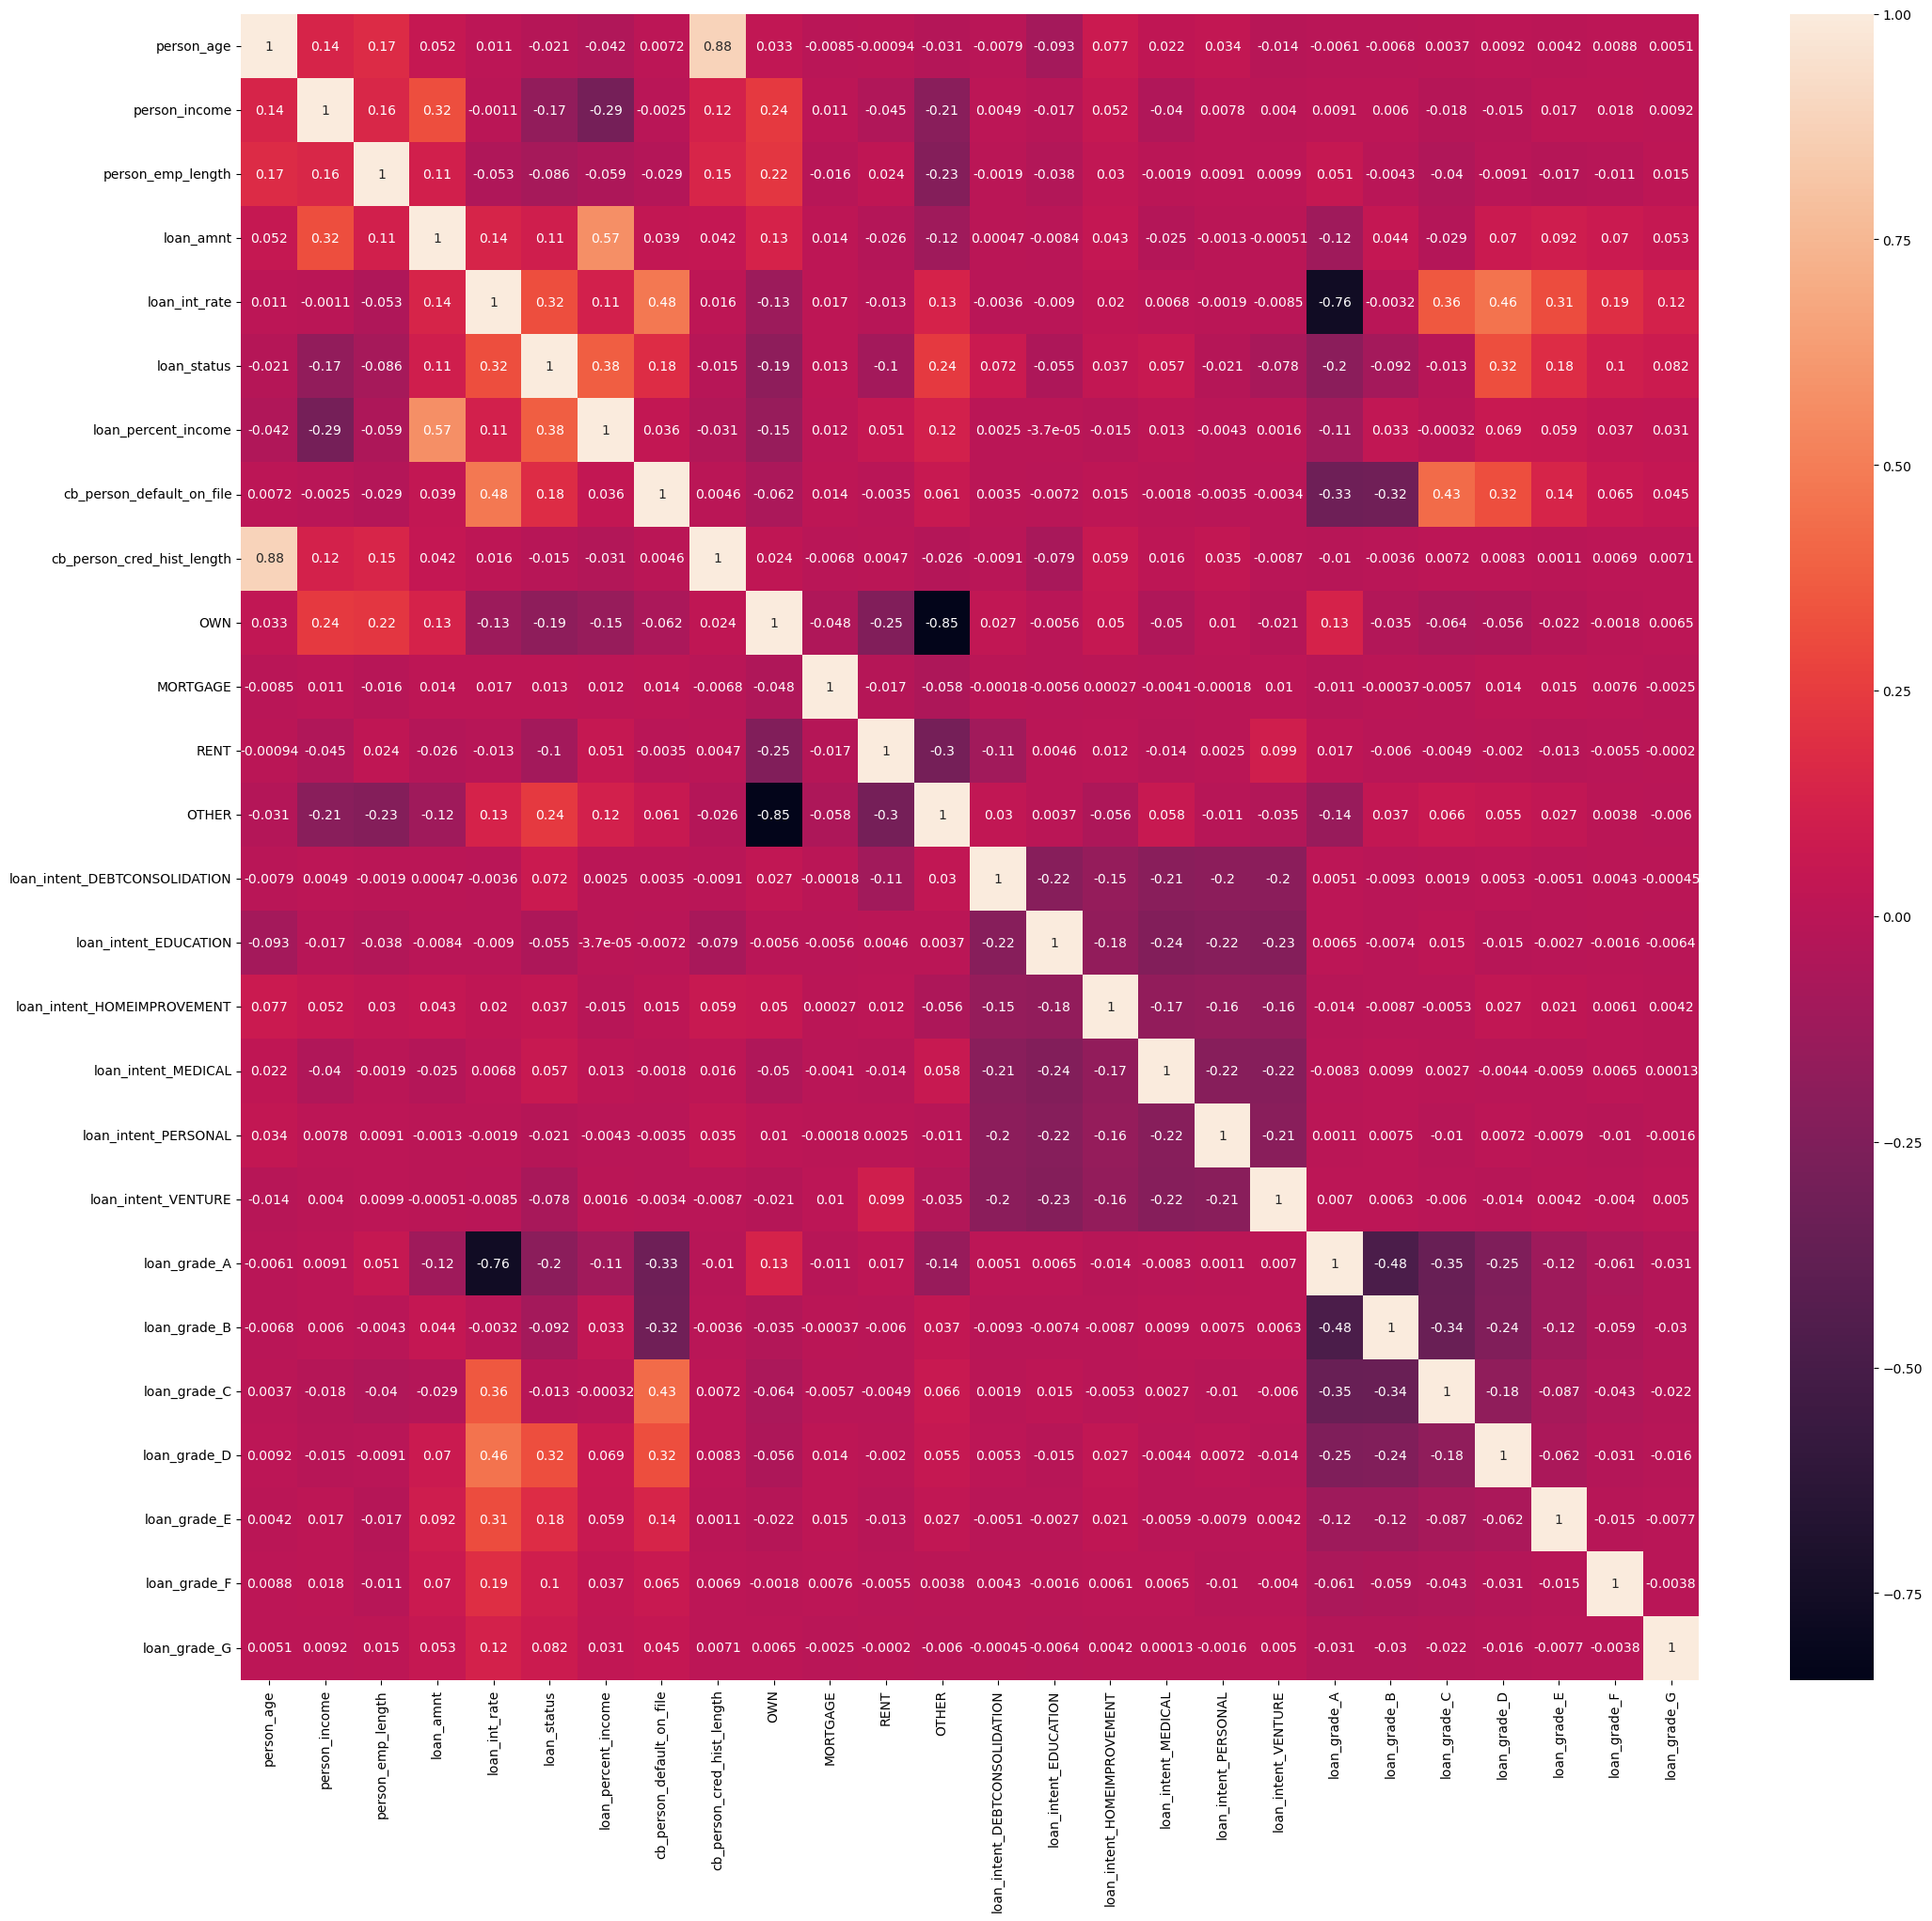

In [85]:
# Heatmap of Correlation
plt.figure(figsize=(25,23))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [86]:
df.corr().loc["loan_status"].sort_values(ascending=False)

loan_status                      1.000000
loan_percent_income              0.379250
loan_int_rate                    0.319320
loan_grade_D                     0.318868
OTHER                            0.238416
loan_grade_E                     0.180130
cb_person_default_on_file        0.179002
loan_amnt                        0.105240
loan_grade_F                     0.101846
loan_grade_G                     0.082311
loan_intent_DEBTCONSOLIDATION    0.071540
loan_intent_MEDICAL              0.056582
loan_intent_HOMEIMPROVEMENT      0.036596
MORTGAGE                         0.012542
loan_grade_C                    -0.012972
cb_person_cred_hist_length      -0.015472
person_age                      -0.020687
loan_intent_PERSONAL            -0.021229
loan_intent_EDUCATION           -0.055298
loan_intent_VENTURE             -0.078189
person_emp_length               -0.085613
loan_grade_B                    -0.092132
RENT                            -0.101981
person_income                   -0

<AxesSubplot:>

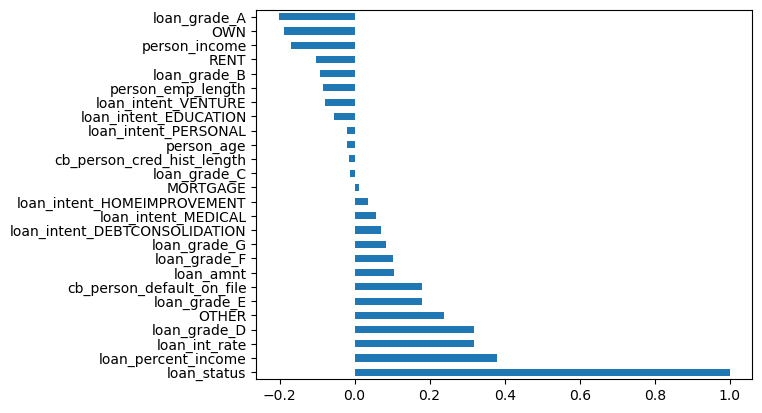

In [87]:
# plot of Correlation of Target feature with independent Feature
d1 = df.corr().loc["loan_status"].sort_values(ascending=False)
d1.plot(kind="barh")

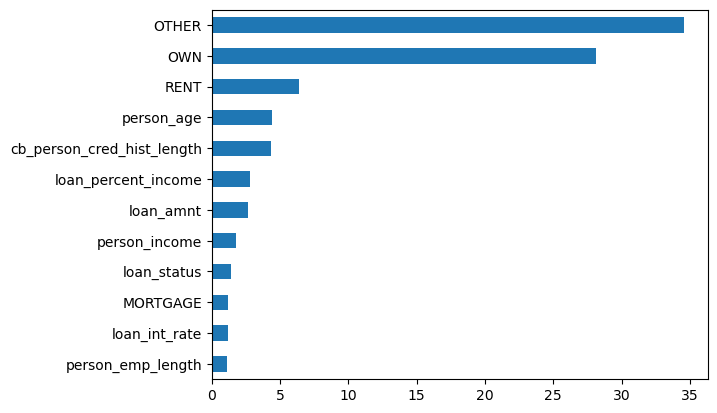

In [88]:
# Checking for relation between independent features after encoding.
x = df1.select_dtypes(exclude="object")
vif_list = []
for i in range(x.shape[1]):
    vif = variance_inflation_factor(x.to_numpy(),i)
    vif_list.append(vif)
x1 = pd.Series(vif_list,index=x.columns)
x1.sort_values().plot(kind="barh")
plt.show()

### 6) Model Selection - 

#### 6.1) Splitting of dataset - 

In [89]:
# Splitting of dataset for the training and testing
x = df.drop("loan_status",axis=1)
y = df["loan_status"]
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.8,random_state=42,stratify=y)

In [90]:
# Checking for the proper splitting happened or not.
print(f"X Train Shape - {x_train.shape}")
print(f"X Test Shape - {x_test.shape}")
print(f"Y Train Shape - {y_train.shape}")
print(f"Y Test Shape - {y_test.shape}")

X Train Shape - (26059, 25)
X Test Shape - (6515, 25)
Y Train Shape - (26059,)
Y Test Shape - (6515,)


We need to scale the data because the range of variables vary a lot within them, so we can treat each feature equally when the model ingests them.

In [91]:
# Normalizing the data to resuce effect of outliers, Here we are using Standard scalar
ss = StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

#### 6.2) Model fitting - 

In [92]:
# Model Training for logistic regression -
lr_model = LogisticRegression()
lr_model.fit(x_train,y_train)

LogisticRegression()

In [93]:
# Model Training for KNN Classifier -
knn_model = KNeighborsClassifier()
knn_model.fit(x_train,y_train)

KNeighborsClassifier()

In [94]:
# Model Training for Descision Tree Classifier -
dt_model = DecisionTreeClassifier()
dt_model.fit(x_train,y_train)

DecisionTreeClassifier()

In [95]:
# Model Training for Random Forest Classifier -
rf_model = RandomForestClassifier()
rf_model.fit(x_train,y_train)

RandomForestClassifier()

In [96]:
# Model Training for CatBoost Classifier -
cb_model = CatBoostClassifier()
cb_model.fit(x_train,y_train)

Learning rate set to 0.041452
0:	learn: 0.6464389	total: 171ms	remaining: 2m 50s
1:	learn: 0.6066599	total: 179ms	remaining: 1m 29s
2:	learn: 0.5736072	total: 188ms	remaining: 1m 2s
3:	learn: 0.5450865	total: 197ms	remaining: 49s
4:	learn: 0.5180020	total: 204ms	remaining: 40.5s
5:	learn: 0.4935978	total: 211ms	remaining: 34.9s
6:	learn: 0.4705197	total: 217ms	remaining: 30.8s
7:	learn: 0.4535595	total: 224ms	remaining: 27.7s
8:	learn: 0.4375668	total: 230ms	remaining: 25.3s
9:	learn: 0.4201766	total: 236ms	remaining: 23.4s
10:	learn: 0.4078615	total: 247ms	remaining: 22.2s
11:	learn: 0.3930569	total: 256ms	remaining: 21.1s
12:	learn: 0.3811051	total: 264ms	remaining: 20s
13:	learn: 0.3710654	total: 269ms	remaining: 19s
14:	learn: 0.3610345	total: 275ms	remaining: 18.1s
15:	learn: 0.3531203	total: 282ms	remaining: 17.3s
16:	learn: 0.3456912	total: 288ms	remaining: 16.7s
17:	learn: 0.3383308	total: 294ms	remaining: 16.1s
18:	learn: 0.3313021	total: 300ms	remaining: 15.5s
19:	learn: 0.32

171:	learn: 0.2025042	total: 1.23s	remaining: 5.93s
172:	learn: 0.2023644	total: 1.24s	remaining: 5.93s
173:	learn: 0.2022054	total: 1.25s	remaining: 5.92s
174:	learn: 0.2021051	total: 1.25s	remaining: 5.91s
175:	learn: 0.2019799	total: 1.26s	remaining: 5.9s
176:	learn: 0.2018997	total: 1.27s	remaining: 5.89s
177:	learn: 0.2016834	total: 1.27s	remaining: 5.88s
178:	learn: 0.2014803	total: 1.28s	remaining: 5.87s
179:	learn: 0.2014364	total: 1.28s	remaining: 5.85s
180:	learn: 0.2013043	total: 1.29s	remaining: 5.84s
181:	learn: 0.2011880	total: 1.3s	remaining: 5.83s
182:	learn: 0.2010755	total: 1.3s	remaining: 5.82s
183:	learn: 0.2009248	total: 1.31s	remaining: 5.8s
184:	learn: 0.2008080	total: 1.31s	remaining: 5.79s
185:	learn: 0.2006658	total: 1.32s	remaining: 5.77s
186:	learn: 0.2005957	total: 1.32s	remaining: 5.76s
187:	learn: 0.2004759	total: 1.33s	remaining: 5.75s
188:	learn: 0.2003985	total: 1.34s	remaining: 5.73s
189:	learn: 0.2002668	total: 1.34s	remaining: 5.72s
190:	learn: 0.20

338:	learn: 0.1842970	total: 2.28s	remaining: 4.45s
339:	learn: 0.1842272	total: 2.29s	remaining: 4.44s
340:	learn: 0.1841556	total: 2.29s	remaining: 4.43s
341:	learn: 0.1840895	total: 2.3s	remaining: 4.42s
342:	learn: 0.1840177	total: 2.3s	remaining: 4.41s
343:	learn: 0.1839194	total: 2.31s	remaining: 4.41s
344:	learn: 0.1838730	total: 2.32s	remaining: 4.4s
345:	learn: 0.1837593	total: 2.33s	remaining: 4.39s
346:	learn: 0.1836307	total: 2.33s	remaining: 4.39s
347:	learn: 0.1835616	total: 2.34s	remaining: 4.38s
348:	learn: 0.1835203	total: 2.34s	remaining: 4.37s
349:	learn: 0.1832921	total: 2.35s	remaining: 4.36s
350:	learn: 0.1832320	total: 2.35s	remaining: 4.36s
351:	learn: 0.1831660	total: 2.36s	remaining: 4.35s
352:	learn: 0.1831245	total: 2.37s	remaining: 4.34s
353:	learn: 0.1829468	total: 2.37s	remaining: 4.33s
354:	learn: 0.1828567	total: 2.38s	remaining: 4.32s
355:	learn: 0.1828109	total: 2.38s	remaining: 4.31s
356:	learn: 0.1827676	total: 2.39s	remaining: 4.3s
357:	learn: 0.18

513:	learn: 0.1700471	total: 3.33s	remaining: 3.15s
514:	learn: 0.1699972	total: 3.34s	remaining: 3.14s
515:	learn: 0.1699048	total: 3.34s	remaining: 3.14s
516:	learn: 0.1698442	total: 3.35s	remaining: 3.13s
517:	learn: 0.1697784	total: 3.35s	remaining: 3.12s
518:	learn: 0.1697040	total: 3.36s	remaining: 3.12s
519:	learn: 0.1696703	total: 3.37s	remaining: 3.11s
520:	learn: 0.1696579	total: 3.38s	remaining: 3.1s
521:	learn: 0.1695796	total: 3.38s	remaining: 3.1s
522:	learn: 0.1695295	total: 3.39s	remaining: 3.09s
523:	learn: 0.1695102	total: 3.39s	remaining: 3.08s
524:	learn: 0.1694385	total: 3.4s	remaining: 3.08s
525:	learn: 0.1693231	total: 3.41s	remaining: 3.07s
526:	learn: 0.1693002	total: 3.42s	remaining: 3.07s
527:	learn: 0.1692233	total: 3.42s	remaining: 3.06s
528:	learn: 0.1691636	total: 3.43s	remaining: 3.05s
529:	learn: 0.1690849	total: 3.44s	remaining: 3.05s
530:	learn: 0.1690305	total: 3.44s	remaining: 3.04s
531:	learn: 0.1689531	total: 3.45s	remaining: 3.04s
532:	learn: 0.1

675:	learn: 0.1595172	total: 4.37s	remaining: 2.1s
676:	learn: 0.1594738	total: 4.38s	remaining: 2.09s
677:	learn: 0.1594169	total: 4.38s	remaining: 2.08s
678:	learn: 0.1593893	total: 4.39s	remaining: 2.08s
679:	learn: 0.1593607	total: 4.4s	remaining: 2.07s
680:	learn: 0.1593282	total: 4.4s	remaining: 2.06s
681:	learn: 0.1592831	total: 4.41s	remaining: 2.06s
682:	learn: 0.1592047	total: 4.42s	remaining: 2.05s
683:	learn: 0.1591687	total: 4.42s	remaining: 2.04s
684:	learn: 0.1591164	total: 4.43s	remaining: 2.04s
685:	learn: 0.1590662	total: 4.43s	remaining: 2.03s
686:	learn: 0.1590095	total: 4.44s	remaining: 2.02s
687:	learn: 0.1589539	total: 4.45s	remaining: 2.02s
688:	learn: 0.1588853	total: 4.45s	remaining: 2.01s
689:	learn: 0.1588219	total: 4.46s	remaining: 2s
690:	learn: 0.1587830	total: 4.46s	remaining: 2s
691:	learn: 0.1587405	total: 4.47s	remaining: 1.99s
692:	learn: 0.1587019	total: 4.47s	remaining: 1.98s
693:	learn: 0.1586765	total: 4.48s	remaining: 1.98s
694:	learn: 0.1585734

853:	learn: 0.1501757	total: 5.44s	remaining: 930ms
854:	learn: 0.1501270	total: 5.44s	remaining: 923ms
855:	learn: 0.1500787	total: 5.45s	remaining: 917ms
856:	learn: 0.1500490	total: 5.46s	remaining: 910ms
857:	learn: 0.1500378	total: 5.47s	remaining: 906ms
858:	learn: 0.1500040	total: 5.48s	remaining: 900ms
859:	learn: 0.1499595	total: 5.49s	remaining: 893ms
860:	learn: 0.1499176	total: 5.49s	remaining: 887ms
861:	learn: 0.1498337	total: 5.5s	remaining: 880ms
862:	learn: 0.1497869	total: 5.5s	remaining: 874ms
863:	learn: 0.1497458	total: 5.51s	remaining: 867ms
864:	learn: 0.1497297	total: 5.51s	remaining: 861ms
865:	learn: 0.1496528	total: 5.52s	remaining: 854ms
866:	learn: 0.1495843	total: 5.53s	remaining: 848ms
867:	learn: 0.1495050	total: 5.53s	remaining: 841ms
868:	learn: 0.1494734	total: 5.54s	remaining: 835ms
869:	learn: 0.1494217	total: 5.54s	remaining: 828ms
870:	learn: 0.1493266	total: 5.55s	remaining: 822ms
871:	learn: 0.1493057	total: 5.55s	remaining: 815ms
872:	learn: 0.

### 7) Model Evaluation -

In [97]:
# Evaluation of Logistic regression Model based on Training data -
y_pred = lr_model.predict(x_train)

cnf_matrix = confusion_matrix(y_train,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci = precision_score(y_train,y_pred)
print(f"Precision - {preci}\n")
recal = recall_score(y_train,y_pred)
print(f"Recall - {recal}\n")
accuracy = accuracy_score(y_train,y_pred)
print(f"Accuracy - {accuracy}\n")
f1 = f1_score(y_train,y_pred)
print(f"F1 Score - {f1}\n")

cnf_report = classification_report(y_train,y_pred)
print(f"Classification report - \n{cnf_report}")

Confusion matrix - 
[[19414   959]
 [ 2495  3191]]

Precision - 0.7689156626506024

Recall - 0.5612029546253957

Accuracy - 0.8674546222034614

F1 Score - 0.6488409922732818

Classification report - 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     20373
           1       0.77      0.56      0.65      5686

    accuracy                           0.87     26059
   macro avg       0.83      0.76      0.78     26059
weighted avg       0.86      0.87      0.86     26059



In [98]:
# Evaluation of Logistic regression Model based on Testing data -
y_pred = lr_model.predict(x_test)

cnf_matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci = precision_score(y_test,y_pred)
print(f"Precision - {preci}\n")
recal = recall_score(y_test,y_pred)
print(f"Recall - {recal}\n")
accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy - {accuracy}\n")
f1 = f1_score(y_test,y_pred)
print(f"F1 Score - {f1}\n")

cnf_report = classification_report(y_test,y_pred)
print(f"Classification report - \n{cnf_report}")
res = pd.DataFrame([["Logistic Regression",preci,recal,accuracy,f1]],
                   columns=["Model","Precision","Recall","Accuracy","f1 Score"])

Confusion matrix - 
[[4863  231]
 [ 656  765]]

Precision - 0.7680722891566265

Recall - 0.5383532723434201

Accuracy - 0.8638526477359939

F1 Score - 0.6330161357054199

Classification report - 
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      5094
           1       0.77      0.54      0.63      1421

    accuracy                           0.86      6515
   macro avg       0.82      0.75      0.77      6515
weighted avg       0.86      0.86      0.85      6515



In [99]:
# Evaluation of KNN classifier Model based on Training data -
y_pred = knn_model.predict(x_train)

cnf_matrix = confusion_matrix(y_train,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci = precision_score(y_train,y_pred)
print(f"Precision - {preci}\n")
recal = recall_score(y_train,y_pred)
print(f"Recall - {recal}\n")
accuracy = accuracy_score(y_train,y_pred)
print(f"Accuracy - {accuracy}\n")
f1 = f1_score(y_train,y_pred)
print(f"F1 Score - {f1}\n")

cnf_report = classification_report(y_train,y_pred)
print(f"Classification report - \n{cnf_report}")

Confusion matrix - 
[[20062   311]
 [ 1791  3895]]

Precision - 0.9260580123632906

Recall - 0.6850158283503341

Accuracy - 0.9193368893664376

F1 Score - 0.7875050545895673

Classification report - 
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     20373
           1       0.93      0.69      0.79      5686

    accuracy                           0.92     26059
   macro avg       0.92      0.83      0.87     26059
weighted avg       0.92      0.92      0.91     26059



In [100]:
# Evaluation of KNN classifer Model based on Testing data -
y_pred = knn_model.predict(x_test)

cnf_matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci1 = precision_score(y_test,y_pred)
print(f"Precision - {preci1}\n")
recal1 = recall_score(y_test,y_pred)
print(f"Recall - {recal1}\n")
accuracy1 = accuracy_score(y_test,y_pred)
print(f"Accuracy - {accuracy1}\n")
f11 = f1_score(y_test,y_pred)
print(f"F1 Score - {f11}\n")

cnf_report = classification_report(y_test,y_pred)
print(f"Classification report - \n{cnf_report}")
res1 = pd.DataFrame([["KNN Classifier",preci1,recal1,accuracy1,f11]],
                   columns=["Model","Precision","Recall","Accuracy","f1 Score"])

Confusion matrix - 
[[4958  136]
 [ 539  882]]

Precision - 0.8664047151277013

Recall - 0.6206896551724138

Accuracy - 0.896392939370683

F1 Score - 0.7232472324723247

Classification report - 
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      5094
           1       0.87      0.62      0.72      1421

    accuracy                           0.90      6515
   macro avg       0.88      0.80      0.83      6515
weighted avg       0.89      0.90      0.89      6515



In [101]:
# Evaluation of Descision Tree classifier Model based on Training data -
y_pred = dt_model.predict(x_train)

cnf_matrix = confusion_matrix(y_train,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci = precision_score(y_train,y_pred)
print(f"Precision - {preci}\n")
recal = recall_score(y_train,y_pred)
print(f"Recall - {recal}\n")
accuracy = accuracy_score(y_train,y_pred)
print(f"Accuracy - {accuracy}\n")
f1 = f1_score(y_train,y_pred)
print(f"F1 Score - {f1}\n")

cnf_report = classification_report(y_train,y_pred)
print(f"Classification report - \n{cnf_report}")

Confusion matrix - 
[[20373     0]
 [    0  5686]]

Precision - 1.0

Recall - 1.0

Accuracy - 1.0

F1 Score - 1.0

Classification report - 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20373
           1       1.00      1.00      1.00      5686

    accuracy                           1.00     26059
   macro avg       1.00      1.00      1.00     26059
weighted avg       1.00      1.00      1.00     26059



In [102]:
# Evaluation of Descision Tree classifer Model based on Testing data -
y_pred = dt_model.predict(x_test)

cnf_matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci2 = precision_score(y_test,y_pred)
print(f"Precision - {preci2}\n")
recal2 = recall_score(y_test,y_pred)
print(f"Recall - {recal2}\n")
accuracy2 = accuracy_score(y_test,y_pred)
print(f"Accuracy - {accuracy2}\n")
f12 = f1_score(y_test,y_pred)
print(f"F1 Score - {f12}\n")

cnf_report = classification_report(y_test,y_pred)
print(f"Classification report - \n{cnf_report}")
res2 = pd.DataFrame([["Descision Tree Classifier",preci2,recal2,accuracy2,f12]],
                   columns=["Model","Precision","Recall","Accuracy","f1 Score"])

Confusion matrix - 
[[4742  352]
 [ 333 1088]]

Precision - 0.7555555555555555

Recall - 0.7656579873328642

Accuracy - 0.8948580199539524

F1 Score - 0.7605732261447047

Classification report - 
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5094
           1       0.76      0.77      0.76      1421

    accuracy                           0.89      6515
   macro avg       0.84      0.85      0.85      6515
weighted avg       0.90      0.89      0.90      6515



In [103]:
# Evaluation of Random Forest classifier Model based on Training data -
y_pred = rf_model.predict(x_train)

cnf_matrix = confusion_matrix(y_train,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci = precision_score(y_train,y_pred)
print(f"Precision - {preci}\n")
recal = recall_score(y_train,y_pred)
print(f"Recall - {recal}\n")
accuracy = accuracy_score(y_train,y_pred)
print(f"Accuracy - {accuracy}\n")
f1 = f1_score(y_train,y_pred)
print(f"F1 Score - {f1}\n")

cnf_report = classification_report(y_train,y_pred)
print(f"Classification report - \n{cnf_report}")

Confusion matrix - 
[[20373     0]
 [    1  5685]]

Precision - 1.0

Recall - 0.9998241294407316

Accuracy - 0.9999616255420393

F1 Score - 0.9999120569870723

Classification report - 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20373
           1       1.00      1.00      1.00      5686

    accuracy                           1.00     26059
   macro avg       1.00      1.00      1.00     26059
weighted avg       1.00      1.00      1.00     26059



In [104]:
# Evaluation of Random Forest classifer Model based on Testing data -
y_pred = rf_model.predict(x_test)

cnf_matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci2 = precision_score(y_test,y_pred)
print(f"Precision - {preci2}\n")
recal2 = recall_score(y_test,y_pred)
print(f"Recall - {recal2}\n")
accuracy2 = accuracy_score(y_test,y_pred)
print(f"Accuracy - {accuracy2}\n")
f12 = f1_score(y_test,y_pred)
print(f"F1 Score - {f12}\n")

cnf_report = classification_report(y_test,y_pred)
print(f"Classification report - \n{cnf_report}")
res3 = pd.DataFrame([["Random Forest Classifier",preci2,recal2,accuracy2,f12]],
                   columns=["Model","Precision","Recall","Accuracy","f1 Score"])

Confusion matrix - 
[[5067   27]
 [ 415 1006]]

Precision - 0.9738625363020329

Recall - 0.7079521463757917

Accuracy - 0.9321565617805065

F1 Score - 0.8198859005704972

Classification report - 
              precision    recall  f1-score   support

           0       0.92      0.99      0.96      5094
           1       0.97      0.71      0.82      1421

    accuracy                           0.93      6515
   macro avg       0.95      0.85      0.89      6515
weighted avg       0.94      0.93      0.93      6515



In [105]:
# Evaluation of CatBoost classifier Model based on Training data -
y_pred = cb_model.predict(x_train)

cnf_matrix = confusion_matrix(y_train,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci = precision_score(y_train,y_pred)
print(f"Precision - {preci}\n")
recal = recall_score(y_train,y_pred)
print(f"Recall - {recal}\n")
accuracy = accuracy_score(y_train,y_pred)
print(f"Accuracy - {accuracy}\n")
f1 = f1_score(y_train,y_pred)
print(f"F1 Score - {f1}\n")

cnf_report = classification_report(y_train,y_pred)
print(f"Classification report - \n{cnf_report}")

Confusion matrix - 
[[20335    38]
 [ 1273  4413]]

Precision - 0.9914625926758032

Recall - 0.7761167780513542

Accuracy - 0.9496910856134158

F1 Score - 0.8706717963894642

Classification report - 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     20373
           1       0.99      0.78      0.87      5686

    accuracy                           0.95     26059
   macro avg       0.97      0.89      0.92     26059
weighted avg       0.95      0.95      0.95     26059



In [106]:
# Evaluation of CatBoost classifer Model based on Testing data -
y_pred = cb_model.predict(x_test)

cnf_matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

preci2 = precision_score(y_test,y_pred)
print(f"Precision - {preci2}\n")
recal2 = recall_score(y_test,y_pred)
print(f"Recall - {recal2}\n")
accuracy2 = accuracy_score(y_test,y_pred)
print(f"Accuracy - {accuracy2}\n")
f12 = f1_score(y_test,y_pred)
print(f"F1 Score - {f12}\n")

cnf_report = classification_report(y_test,y_pred)
print(f"Classification report - \n{cnf_report}")
res4 = pd.DataFrame([["Catboost Classifier",preci2,recal2,accuracy2,f12]],
                   columns=["Model","Precision","Recall","Accuracy","f1 Score"])

Confusion matrix - 
[[5072   22]
 [ 396 1025]]

Precision - 0.9789875835721108

Recall - 0.7213230119634061

Accuracy - 0.93584036838066

F1 Score - 0.8306320907617504

Classification report - 
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      5094
           1       0.98      0.72      0.83      1421

    accuracy                           0.94      6515
   macro avg       0.95      0.86      0.90      6515
weighted avg       0.94      0.94      0.93      6515



In [107]:
# Creating new dataframe by joining 3 dataframes of evaluation values of different models
result = pd.concat([res,res1,res2,res3,res4],ignore_index=True)
result

Model  Precision    Recall  Accuracy  f1 Score
0        Logistic Regression   0.768072  0.538353  0.863853  0.633016
1             KNN Classifier   0.866405  0.620690  0.896393  0.723247
2  Descision Tree Classifier   0.755556  0.765658  0.894858  0.760573
3   Random Forest Classifier   0.973863  0.707952  0.932157  0.819886
4        Catboost Classifier   0.978988  0.721323  0.935840  0.830632

As observed, for the context of our project, we are aiming for recall. `Descision Tree` presents the highest
recall score. Lets assume we are aiming more for recall and  precision, we could then, take advantage of f1-score, 
as its the harmonic average between precision and recall. Thus, the algorithm that satisfies 
this need is `Catboost Classifier`.

#### Probability Distribution

In [108]:
# Storing predicted probabilities for class 1 
y_pred_lr_prob = lr_model.predict_proba(x_test)[:,1]
y_pred_knn_prob = knn_model.predict_proba(x_test)[:,1]
y_pred_dt_prob = dt_model.predict_proba(x_test)[:,1]
y_pred_rf_prob = rf_model.predict_proba(x_test)[:,1]
y_pred_cb_prob = cb_model.predict_proba(x_test)[:,1]

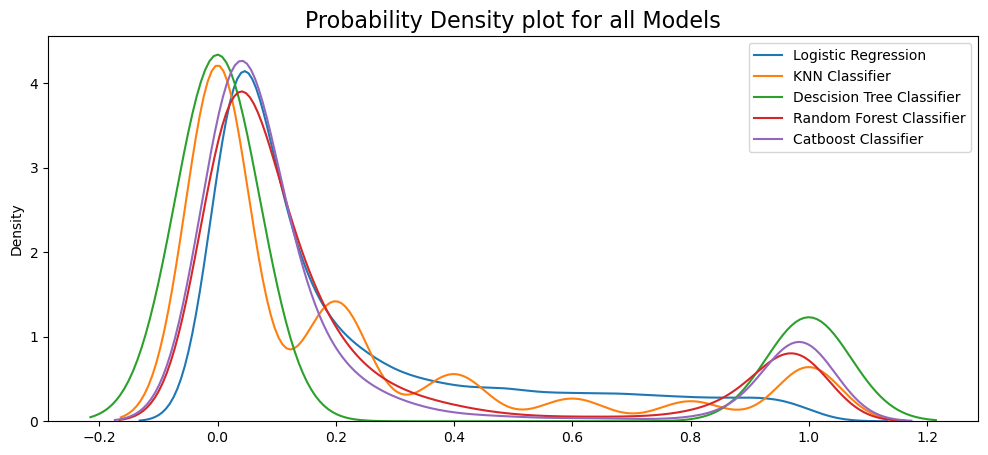

In [109]:
# Plotting kdeplot of Probability desnsity for all models
plt.figure(figsize=(12,5))
sns.kdeplot(y_pred_lr_prob,label="Logistic Regression")
sns.kdeplot(y_pred_knn_prob,label="KNN Classifier")
sns.kdeplot(y_pred_dt_prob,label="Descision Tree Classifier")
sns.kdeplot(y_pred_rf_prob,label="Random Forest Classifier")
sns.kdeplot(y_pred_cb_prob,label="Catboost Classifier")
plt.title("Probability Density plot for all Models",fontsize=16)
plt.legend()
plt.show()

As observed, in general all the algorithms presents most probabilities concentrated around `0`. However, 
`DescisionTreeClassifier` presents the largest amount of probabilities concentrated around `0`, while 
`Catboost Classifier` presenting the least with a moderate distributed probabilities around other values. 
The term `Catboost Classifier` suits best for the context and challenge of our project.

### Cross Validatation

As observed, the original full data set is imbalanced, so we'll need to adopt the `StratifiedKFold` as our K-folding strategy for cross validation.

In [111]:
# Cross Validation of descision tree model
cv = StratifiedKFold(n_splits=5)

In [112]:
cv_scores = cross_val_score(cb_model, x, np.ravel(y), cv = cv, scoring='precision', n_jobs=-1)

# prints the average precision and standard deviation of the scores
print("Average precision: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(cb_model, x, np.ravel(y), cv = cv, scoring='recall', n_jobs=-1)

# prints the average recall and standard deviation of the scores
print("\nAverage recall: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(cb_model, x, np.ravel(y), cv = cv, scoring='f1', n_jobs=-1)

# prints the average f1-score and standard deviation of the scores
print("\nAverage f1-score: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

# calculates the cross validation scores
cv_scores = cross_val_score(cb_model, x, np.ravel(y), cv = cv, scoring='roc_auc', n_jobs=-1)

# prints the average roc_auc and standard deviation of the scores
print("\nAverage ROC AUC: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))


cv_scores = cross_val_score(cb_model, x, np.ravel(y), cv = cv, scoring='accuracy', n_jobs=-1)
print("\nAverage accuracy: %0.4f (+/- %0.4f)" % (cv_scores.mean(), cv_scores.std() * 2))

Average precision: 0.9210 (+/- 0.0976)

Average recall: 0.7217 (+/- 0.1321)

Average f1-score: 0.8057 (+/- 0.0608)

Average ROC AUC: 0.9188 (+/- 0.0420)

Average accuracy: 0.9247 (+/- 0.0181)


### Pruning - for reducing Overfitting

In [113]:
# Model training of Dt for ccp alpha values
dt_clf_ccp = DecisionTreeClassifier(random_state=10,ccp_alpha=0.0)
dt_clf_ccp.fit(x_train,y_train)

DecisionTreeClassifier(random_state=10)

In [114]:
result1 = dt_clf_ccp.cost_complexity_pruning_path(x_train,y_train)
ccp_list = result1["ccp_alphas"]
ccp_list

array([0.00000000e+00, 1.89991189e-05, 1.90723354e-05, 1.90769575e-05,
       1.91179610e-05, 1.91562318e-05, 2.13191433e-05, 2.15658111e-05,
       2.23851005e-05, 2.41616958e-05, 2.43038234e-05, 2.43647352e-05,
       2.45170148e-05, 2.45170148e-05, 2.45990115e-05, 2.46354545e-05,
       2.46526821e-05, 2.47302062e-05, 2.47577148e-05, 2.48305316e-05,
       2.49269983e-05, 2.49269983e-05, 2.49433977e-05, 2.49738536e-05,
       2.49738536e-05, 2.50015408e-05, 2.50144615e-05, 2.50813451e-05,
       2.50909917e-05, 2.51002744e-05, 2.51341479e-05, 2.51341479e-05,
       2.52011366e-05, 2.52122043e-05, 2.52276529e-05, 2.52276529e-05,
       2.52372561e-05, 2.52889148e-05, 2.53018404e-05, 2.53048962e-05,
       2.53108127e-05, 2.53393246e-05, 2.53679890e-05, 2.53815312e-05,
       2.53975881e-05, 2.54015325e-05, 2.54135483e-05, 2.54146629e-05,
       2.54179205e-05, 2.54189786e-05, 2.54310380e-05, 2.54899430e-05,
       2.55829720e-05, 2.55829720e-05, 2.84167818e-05, 2.84422453e-05,
      

In [115]:
test_acc_list = []
train_acc_list = []
for ccp in ccp_list:
    dt_clf_ccp = DecisionTreeClassifier(random_state=10,ccp_alpha=ccp)
    dt_clf_ccp.fit(x_train,y_train)
    train_acc_list.append(dt_clf_ccp.score(x_train,y_train))
    test_acc_list.append(dt_clf_ccp.score(x_test,y_test))

In [116]:
index = np.argmax(test_acc_list)
index

706

In [117]:
# best value of ccp alpha
cc_val = ccp_list[index]
print("Best Value of CCP Alpha - ",cc_val)

Best Value of CCP Alpha -  0.00014924755385420764


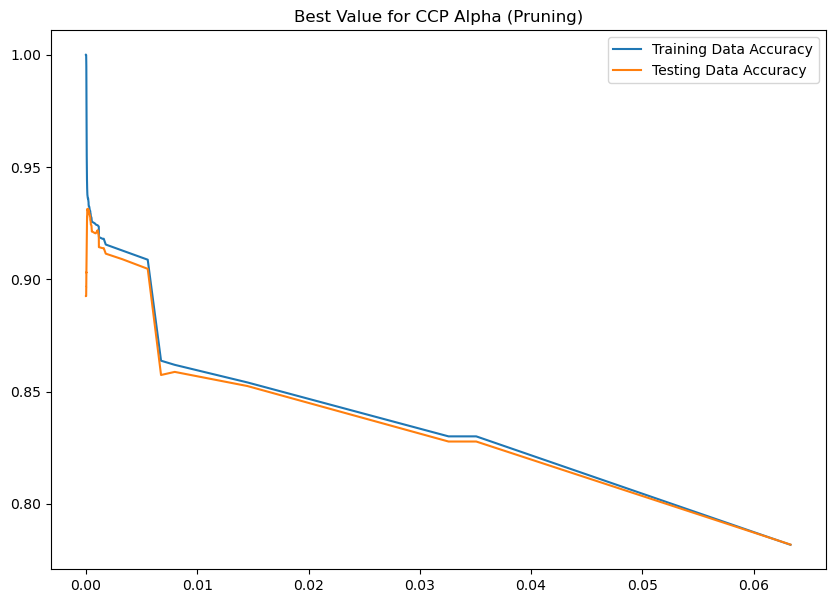

In [118]:
# Plot of Accuracies to take best value of ccp alpha from graph
fig,ax = plt.subplots()
ax.figure.set_size_inches(10,7)
ax.plot(ccp_list,train_acc_list,label="Training Data Accuracy")
ax.plot(ccp_list,test_acc_list,label="Testing Data Accuracy")
ax.legend()
plt.title("Best Value for CCP Alpha (Pruning)")
plt.show()

In [119]:
dt_clf_ccp = DecisionTreeClassifier(random_state=10,ccp_alpha=0.00014924755385420764)
dt_clf_ccp.fit(x_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.00014924755385420764, random_state=10)

In [120]:
# Training Accuracy after pruning for the Descision Tree Model -
y_pred_train = dt_clf_ccp.predict(x_train)

cnf_matrix = confusion_matrix(y_train,y_pred_train)
print(f"Confusion matrix - \n{cnf_matrix}\n")

accuracy = accuracy_score(y_train,y_pred_train)
print(f"Accuracy - {accuracy}\n")

preci = precision_score(y_train,y_pred_train)
print(f"Precision - {preci}\n")

recal = recall_score(y_train,y_pred_train)
print(f"Recall - {recal}\n")

f1 = f1_score(y_train,y_pred_train)
print(f"F1 Score - {f1}\n")

clf_report = classification_report(y_train,y_pred_train)
print(f"Classification report - \n{clf_report}")

Confusion matrix - 
[[20244   129]
 [ 1516  4170]]

Accuracy - 0.9368740166545148

Precision - 0.9699930216329379

Recall - 0.7333802321491383

F1 Score - 0.8352528793189784

Classification report - 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     20373
           1       0.97      0.73      0.84      5686

    accuracy                           0.94     26059
   macro avg       0.95      0.86      0.90     26059
weighted avg       0.94      0.94      0.93     26059



In [121]:
# Testing Accuracy after pruning for the Descision Tree Model -
y_pred = dt_clf_ccp.predict(x_test)

cnf_matrix = confusion_matrix(y_test,y_pred)
print(f"Confusion matrix - \n{cnf_matrix}\n")

accuracy = accuracy_score(y_test,y_pred)
print(f"Accuracy - {accuracy}\n")

preci = precision_score(y_test,y_pred)
print(f"Precision - {preci}\n")

recal = recall_score(y_test,y_pred)
print(f"Recall - {recal}\n")

f1 = f1_score(y_test,y_pred)
print(f"F1 Score - {f1}\n")

clf_report = classification_report(y_test,y_pred)
print(f"Classification report - \n{clf_report}")

Confusion matrix - 
[[5057   37]
 [ 410 1011]]

Accuracy - 0.9313891020721412

Precision - 0.9646946564885496

Recall - 0.7114707952146376

F1 Score - 0.818955042527339

Classification report - 
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      5094
           1       0.96      0.71      0.82      1421

    accuracy                           0.93      6515
   macro avg       0.94      0.85      0.89      6515
weighted avg       0.93      0.93      0.93      6515



Here, We have got the best values of accuracy, precision, recall and f1 score. Descision Tree model 
after pruning and avoiding overfitting.
Descision Tree Model Accuracies -
Training -
   - Accuracy - 0.9368740166545148
   - Precision - 0.9699930216329379
   - Recall - 0.7333802321491383
   - F1 Score - 0.8352528793189784
    
Testing - 
   - Accuracy - 0.9313891020721412
   - Precision - 0.9646946564885496
   - Recall - 0.7114707952146376
   - F1 Score - 0.818955042527339
   
Cat Boost Model Accuracies -

Training - 
   - Accuracy - 0.9496910856134158
   - Precision - 0.9914625926758032
   - Recall - 0.7761167780513542
   - F1 Score - 0.8706717963894642

Testing - 
   - Accuracy - 0.93584036838066 
   - Precision - 0.9789875835721108
   - Recall - 0.7213230119634061
   - F1 Score - 0.8306320907617504
    
From above Insights its clear that Catboost Classifier mosel is working better than all other models so we are accepting `Catboost Classifier` Model

### 8) User Input Testing - 

In [122]:
x.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'OWN', 'MORTGAGE', 'RENT', 'OTHER',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G'],
      dtype='object')

In [123]:
# Writting code to create dictionary of all encoded Features -
cb_person_default_on_file_val = {'N': 1.0, 'Y': 0.0}
encoded = {"cb_person_default_on_file_val" : cb_person_default_on_file_val,
           "columns":list(x.columns)}
encoded

{'cb_person_default_on_file_val': {'N': 1.0, 'Y': 0.0},
 'columns': ['person_age',
  'person_income',
  'person_emp_length',
  'loan_amnt',
  'loan_int_rate',
  'loan_percent_income',
  'cb_person_default_on_file',
  'cb_person_cred_hist_length',
  'OWN',
  'MORTGAGE',
  'RENT',
  'OTHER',
  'loan_intent_DEBTCONSOLIDATION',
  'loan_intent_EDUCATION',
  'loan_intent_HOMEIMPROVEMENT',
  'loan_intent_MEDICAL',
  'loan_intent_PERSONAL',
  'loan_intent_VENTURE',
  'loan_grade_A',
  'loan_grade_B',
  'loan_grade_C',
  'loan_grade_D',
  'loan_grade_E',
  'loan_grade_F',
  'loan_grade_G']}

In [124]:
# Checking for value counts in cb_person_default_on_file -
df["cb_person_default_on_file"].value_counts()

0.0    26830
1.0     5744
Name: cb_person_default_on_file, dtype: int64

In [125]:
# Creating json file of encoded so we can further use it.
with open("encoded.json","w") as f:
    json.dump(encoded,f)

In [127]:
# Checking for the 1st entry in the data.
df_2.iloc[0]

person_age                           21
person_income                      9600
person_home_ownership               OWN
person_emp_length                   5.0
loan_intent                   EDUCATION
loan_grade                            B
loan_amnt                          1000
loan_int_rate                     11.14
loan_status                           0
loan_percent_income                 0.1
cb_person_default_on_file             N
cb_person_cred_hist_length            2
Name: 0, dtype: object

In [126]:
# Creating variables and assigning known values for user input testing - 
person_age                   = 21
person_income                = 9600
person_home_ownership        = "OWN"       # OneHotEncoded
person_emp_length            = 5.0
loan_intent                  = "EDUCATION" # OneHotEncoded
loan_grade                   = "B"         # OneHotEncoded
loan_amnt                    = 1000
loan_int_rate                = 11.14
loan_percent_income          = 0.1
cb_person_default_on_file    = "N"
cb_person_cred_hist_length   = 2

In [128]:
# Creating array of values so we can pass the values to the our model -
column_names = x.columns
cb_person_default_on_file_1 = cb_person_default_on_file_val[cb_person_default_on_file]
array = np.zeros(len(x.columns),dtype=float)
array[0] = person_age
array[1] = person_income
array[2] = person_emp_length
array[3] = loan_amnt
array[4] = loan_int_rate
array[5] = loan_percent_income
array[6] = cb_person_default_on_file_1
array[7] = cb_person_cred_hist_length

person_home_ownership_index = np.where(column_names == person_home_ownership)[0][0]
array[person_home_ownership_index] = 1

loan_intent_1 = "loan_intent_" + loan_intent
loan_intent_index = np.where(column_names == loan_intent_1)[0][0]
array[loan_intent_index] = 1

loan_grade_1 = "loan_grade_" + loan_grade
loan_grade_index = np.where(column_names == loan_grade_1)[0][0]
array[loan_grade_index] = 1

In [129]:
# printing input array for model after scaling -
array1 = ss.transform([array])
array1

array([[-1.0853287 , -1.0901131 ,  0.062468  , -1.36060639,  0.0371939 ,
        -0.65867242,  2.15786757, -0.93729634,  1.19951636, -0.05787712,
        -0.29528962, -1.01293915, -0.43696901,  2.01153721, -0.35214761,
        -0.4780196 , -0.45127482, -0.46213692, -0.70245144,  1.46197489,
        -0.50037172, -0.35414076, -0.17461034, -0.08772276, -0.04428245]])

In [130]:
# predicting values based on user input from the best model.
Predict_Credit_risk = np.around(cb_model.predict(array1)[0])
print("Predicted Credit Risk - ",Predict_Credit_risk)

Predicted Credit Risk -  0


In [131]:
# Creating pickle file for Catboost model after pruning -
with open("cb_model.pkl","wb") as f1:
    pickle.dump(cb_model,f1)

In [132]:
# Creating pickle file for Stander Scalar -
with open("Scaling.pkl","wb") as f2:
    pickle.dump(ss,f2)